In [1]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import FloatImage
import base64
import requests
from zipfile import ZipFile
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

In [2]:
#Loading of the dataset
#The windparks
df=pd.read_csv('Landkreis_id_windanlage.csv', index_col=None)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name_x                    4251 non-null   object 
 1   Baujahr                   4251 non-null   object 
 2   Anfangjahr                4251 non-null   object 
 3   Gesamtleistung (MW)       4251 non-null   float64
 4   Anzahl                    4251 non-null   int64  
 5   Typ (WKA)                 4251 non-null   object 
 6   Ort                       4251 non-null   object 
 7   Landkreis                 4251 non-null   object 
 8   Projektierer / Betreiber  3064 non-null   object 
 9   Bemerkungen               1802 non-null   object 
 10  Latitude                  4251 non-null   object 
 11  Longitude                 4251 non-null   object 
 12  Land                      4251 non-null   object 
 13  Code                      4251 non-null   object 
 14  NUTS 1.1

In [4]:
# Convert 'Age' column to integers, replacing non-numeric with NaN
df['Anfangjahr'] = pd.to_numeric(df['Anfangjahr'], errors='coerce')
df=df.loc[df['Anfangjahr']!=1]

In [5]:
df

Name_x                  Baujahr  \
0       Forschungswindkraftanlage RedoxWind                    2017,   
1          Windkraftanlage Alexanderschanze                    2003,   
2                Windkraftanlage Alpirsbach               1999,2013,   
3                  Windkraftanlage Auenberg                    1990,   
4     Windkraftanlage auf dem Hohwartsattel                    1992,   
...                                     ...                      ...   
4246                Windpark Wulkow-Treplin  2007, 201,0 20,12 2,021   
4247                        Windpark Wutike                    2009,   
4248                    Windpark Zehlendorf                    2003,   
4249                  Windpark Zitz-Warchau                    2003,   
4250                        Windpark Zossen        2002, 200,3 20,04   

      Anfangjahr  Gesamtleistung (MW)  Anzahl  \
0         2017.0                2.000       1   
1         2003.0                1.500       1   
2         1999.0                2.300       1   
3         1990.0                0.095       1   
4         1992.0                0.300       1   
...          ...                  ...     ...   
4246      2007.0               40.600      14   
4247      2009.0               16.000       8   
4248      2003.0                2.000       3   
4249      2003.0               30.000      20   
4250      2002.0                7.800       4   

                                              Typ (WKA)  \
0                                        Qreon Q82 (1×)   
1                                      Südwind S70 (1×)   
2                                  Enercon E-70 E4 (1×)   
3                                 Reymo DANmark 22 (1×)   
4                                     Enercon E-33 (1×)   
...                                                 ...   
4246  Vestas V90-2.0MW (8×) Enercon E-82 (1×) Enerco...   
4247                                  Enercon E-82 (8×)   
4248                              Vestas V47-660kW (3×)   
4249                        NEG Micon NM 64c/1500 (20×)   
4250  Enercon E-66/18.70 (1×) Enercon E-66/20.70 (1×...   

                               Ort Landkreis  \
0                        Karlsruhe        KA   
1          Bad Peterstal-Griesbach        OG   
2                      Römlinsdorf       FDS   
3                  Hausen vor Wald        VS   
4                         Breitnau        FR   
...                            ...       ...   
4246  Wulkow Alt Zeschdorf Treplin       MOL   
4247                        Wutike        PR   
4248                    Zehlendorf       OHV   
4249                  Warchau Zitz        PM   
4250                        Zossen        TF   

                         Projektierer / Betreiber  \
0                                  Fraunhofer ICT   
1     Schmalz, Windenergieanlage „Bei der Schanz“   
2     Windkraft Römlinsdorf, Stadtwerke Stuttgart   
3                      Pionier-Windmühle Auenberg   
4               Christian Riesterer, Uwe Tischler   
...                                           ...   
4246                                     PNE Wind   
4247                                  Denker&Wulf   
4248                                EFI Wind GmbH   
4249                WKN Windkraft Nord;\nPNE Wind   
4250                           Energiequelle GmbH   

                                            Bemerkungen      Latitude  \
0     Forschungsprojekt mit kombiniertem Batteriespe...    49° 1′ 9″    
1     errichtet an der Schwarzwaldhochstraße im Bere...  48° 28′ 22″    
2     Repowering 2013 (1× Enercon E-70 E4 statt 1× F...   48° 20′ 0″    
3     (*); erste kommerziell betriebene Windkraftanl...  47° 53′ 19″    
4                                                   (*)  47° 56′ 14″    
...                                                 ...           ...   
4246  September 2022 Upgrade der Vestas V150-5.6MW a...   52° 24′ 1″    
4247                                                NaN   53° 0′ 23″    
424

In [6]:
df['Typ (WKA)'].nunique()

2793

In [7]:
df['NUTS 1.1'].unique()

array(['Baden-Württemberg', 'Thüringen', 'Schleswig-Holstein',
       'Nordrhein-Westfalen', 'Sachsen-Anhalt', 'Sachsen',
       'Rheinland-Pfalz', 'Saarland', 'DEC', 'Bayern',
       'Mecklenburg-Vorpommern', 'DE8', 'Niedersachsen', 'Hamburg',
       'Bremen', 'DE5', 'Hessen', 'Berlin', 'Brandenburg', 'DE4'],
      dtype=object)

In [8]:
# Define the mapping for NUTS codes to Bundesländer
nuts_mapping = {
    'DEC': 'Saarland',
    'DE4': 'Brandenburg',
    'DE5': 'Bremen',
    'DE8': 'Mecklenburg-Vorpommern'
}

# Apply the mapping to the 'NUTS 1.1' column
df['NUTS 1.1'] = df['NUTS 1.1'].replace(nuts_mapping)

# Check the updated DataFrame
print(df['NUTS 1.1'].unique())

['Baden-Württemberg' 'Thüringen' 'Schleswig-Holstein'
 'Nordrhein-Westfalen' 'Sachsen-Anhalt' 'Sachsen' 'Rheinland-Pfalz'
 'Saarland' 'Bayern' 'Mecklenburg-Vorpommern' 'Niedersachsen' 'Hamburg'
 'Bremen' 'Hessen' 'Berlin' 'Brandenburg']


I am going now to find out how many types (WKA) there are really. Because, 2793 is the nuber of various lists for each Windcraft/Wind Park, the number of used Types (WKA) is smaller.

In [9]:

# Function to parse the windcraft data dynamically
def parse_windcraft(row):
    matches = re.findall(r'([\w\s\-\/.]+)\s\((\d+)×\)', row)
    return [(match[0].strip(), int(match[1])) for match in matches]


# Apply parsing and explode the dataframe
df['parsed'] = df['Typ (WKA)'].apply(parse_windcraft)
df_exploded = df.explode('parsed')



In [10]:
df_exploded


Name_x            Baujahr  Anfangjahr  \
0       Forschungswindkraftanlage RedoxWind              2017,      2017.0   
1          Windkraftanlage Alexanderschanze              2003,      2003.0   
2                Windkraftanlage Alpirsbach         1999,2013,      1999.0   
3                  Windkraftanlage Auenberg              1990,      1990.0   
4     Windkraftanlage auf dem Hohwartsattel              1992,      1992.0   
...                                     ...                ...         ...   
4248                    Windpark Zehlendorf              2003,      2003.0   
4249                  Windpark Zitz-Warchau              2003,      2003.0   
4250                        Windpark Zossen  2002, 200,3 20,04      2002.0   
4250                        Windpark Zossen  2002, 200,3 20,04      2002.0   
4250                        Windpark Zossen  2002, 200,3 20,04      2002.0   

      Gesamtleistung (MW)  Anzahl  \
0                   2.000       1   
1                   1.500       1   
2                   2.300       1   
3                   0.095       1   
4                   0.300       1   
...                   ...     ...   
4248                2.000       3   
4249               30.000      20   
4250                7.800       4   
4250                7.800       4   
4250                7.800       4   

                                              Typ (WKA)  \
0                                        Qreon Q82 (1×)   
1                                      Südwind S70 (1×)   
2                                  Enercon E-70 E4 (1×)   
3                                 Reymo DANmark 22 (1×)   
4                                     Enercon E-33 (1×)   
...                                                 ...   
4248                              Vestas V47-660kW (3×)   
4249                        NEG Micon NM 64c/1500 (20×)   
4250  Enercon E-66/18.70 (1×) Enercon E-66/20.70 (1×...   
4250  Enercon E-66/18.70 (1×) Enercon E-66/20.70 (1×...   
4250  Enercon E-66/18.70 (1×) Enercon E-66/20.70 (1×...   

                          Ort Landkreis  \
0                   Karlsruhe        KA   
1     Bad Peterstal-Griesbach        OG   
2                 Römlinsdorf       FDS   
3             Hausen vor Wald        VS   
4                    Breitnau        FR   
...                       ...       ...   
4248               Zehlendorf       OHV   
4249             Warchau Zitz        PM   
4250                   Zossen        TF   
4250                   Zossen        TF   
4250                   Zossen        TF   

                         Projektierer / Betreiber  \
0                                  Fraunhofer ICT   
1     Schmalz, Windenergieanlage „Bei der Schanz“   
2     Windkraft Römlinsdorf, Stadtwerke Stuttgart   
3                      Pionier-Windmühle Auenberg   
4               Christian Riesterer, Uwe Tischler   
...                                           ...   
4248                                EFI Wind GmbH   
4249                WKN Windkraft Nord;\nPNE Wind   
4250                           Energiequelle GmbH   
4250                           Energiequelle GmbH   
4250                           Energiequelle GmbH   

                                            Bemerkungen      Latitude  \
0     Forschungsprojekt mit kombiniertem Batteriespe...    49° 1′ 9″    
1     errichtet an der Schwarzwaldhochstraße im Bere...  48° 28′ 22″    
2     Repowering 2013 (1× Enercon E-70 E4 statt 1× F...   48° 20′ 0″    
3     (*); erste kommerziell betriebene Windkraftanl...  47° 53′ 19″    
4                                                   (*)  47° 56′ 14″    
...                                                 ...           ...   
4248                                                NaN  52° 47′ 18″    
4249                                                NaN  52° 20′ 17″    
4250                                                NaN  52° 12′ 26″    
4250                                                NaN  52° 1

In [11]:
problematic_rows = df_exploded[df_exploded['parsed'].isna()]
print(problematic_rows)

                          Name_x               Baujahr  Anfangjahr  \
360   Windkraftanlage Lammersweg            1992,2000,      1992.0   
2075              Windpark Niese  1993,1994,1995,2024,      1993.0   
2774          Windpark Stretense                 2009,      2009.0   

      Gesamtleistung (MW)  Anzahl              Typ (WKA)                Ort  \
360                   0.5       1      Jacobs 41/500 (1)  Wesselburenerkoog   
2075                 13.5       3  Nordex N149/4500 (3x)              Niese   
2774                  8.0       4    Vestas - V-90 - 2,0      Lüskow/Butzow   

     Landkreis Projektierer / Betreiber  \
360        HEI                  L＆W OHG   
2075       LIP                      NaN   
2774        VG                 Alterric   

                                            Bemerkungen       Latitude  \
360   2013 Rückbau der Jacobs 33, diese war ein Zwei...   54° 14′ 14″    
2075  Repowering im Gange (3× Nordex N149/4500 statt...     51.86749°    
2774   

In [12]:
# Split into separate columns for type and count
# Ensure all rows in the 'parsed' column are valid tuples
df_exploded['type'] = df_exploded['parsed'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df_exploded['count'] = df_exploded['parsed'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

# Drop unnecessary columns
df_exploded = df_exploded.drop(columns=['parsed', 'Typ (WKA)'])

# Aggregate data
# Total counts for each type
type_totals = df_exploded.groupby('type')['count'].sum().sort_values(ascending=False)

# Diversity of types per wind park
type_diversity = df_exploded.groupby('Name_x')['type'].nunique()

# Total windcrafts per park
park_totals = df_exploded.groupby('Name_x')['count'].sum()

# Example Outputs
print(type_totals.head(10))   # Top 10 windcraft types
print(type_diversity.head(10))  # Type diversity per park
print(park_totals.head(10))   # Total windcrafts per park

type
Enercon E-82 E2       1619.0
Vestas V90-2.0MW      1325.0
Enercon E-66/18.70    1145.0
Enercon E-70 E4       1092.0
Enercon E-70           995.0
Enercon E-101          957.0
Enercon E-40/5.40      924.0
Enercon E-115          921.0
Enercon E-82           828.0
Nordex N117/2400       715.0
Name: count, dtype: float64
Name_x
Bürgerwindpark Mittelholstein (Pemeln)                          2
Bürgerwindpark Mittelholstein (Seefeld-Gokels-Lütjenwestedt)    1
Bürgerwindpark Obere Arlau                                      4
DLR-Forschungspark Krummendeich                                 1
Energiepark Styrumer Ruhrbogen                                  1
EuroWindPark Aachen                                             4
Forschungswindkraftanlage RedoxWind                             1
I. Windkraft­anlage Pankow                                      1
II. und VI.  Wind­kraft­anlage Pankow                           2
III. und IV. Wind­kraft­anlage Pankow                           1
Name: type

In [13]:
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8827 entries, 0 to 4250
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name_x                    8827 non-null   object 
 1   Baujahr                   8827 non-null   object 
 2   Anfangjahr                8825 non-null   float64
 3   Gesamtleistung (MW)       8827 non-null   float64
 4   Anzahl                    8827 non-null   int64  
 5   Ort                       8827 non-null   object 
 6   Landkreis                 8827 non-null   object 
 7   Projektierer / Betreiber  7005 non-null   object 
 8   Bemerkungen               4890 non-null   object 
 9   Latitude                  8827 non-null   object 
 10  Longitude                 8827 non-null   object 
 11  Land                      8827 non-null   object 
 12  Code                      8827 non-null   object 
 13  NUTS 1.1                  8827 non-null   object 
 14  NUTS 2.1     

In [14]:
# Total counts for each type grouped by year and type
type_totals = (
    df_exploded.groupby(['type', 'Anfangjahr'])['count']
    .sum()
    .reset_index()  # Reset index to sort by multiple columns
    .sort_values(by=['Anfangjahr', 'count'], ascending=[True, False])  # Sort by year ascending, count descending
)
type_totals

type  Anfangjahr  count
2386          Vestas V15-55kW      1983.0    1.0
2000              Stampa 60kW      1984.0    1.0
1142        MAN Aeroman 12/20      1985.0    1.0
489         Enercon E-40/5.40      1986.0    2.0
468              Enercon E-33      1986.0    1.0
...                       ...         ...    ...
2744  eno energy eno160-6.0MW      2024.0    3.0
252      Enercon E-115 EP3 E3      2024.0    2.0
2342       Vestas V136-3.45MW      2024.0    2.0
1043   GE Wind Energy 6.1-158      2024.0    1.0
1373         Nordex N117/3600      2024.0    1.0

[2765 rows x 3 columns]

In [15]:
type_totals['type'].nunique()

514

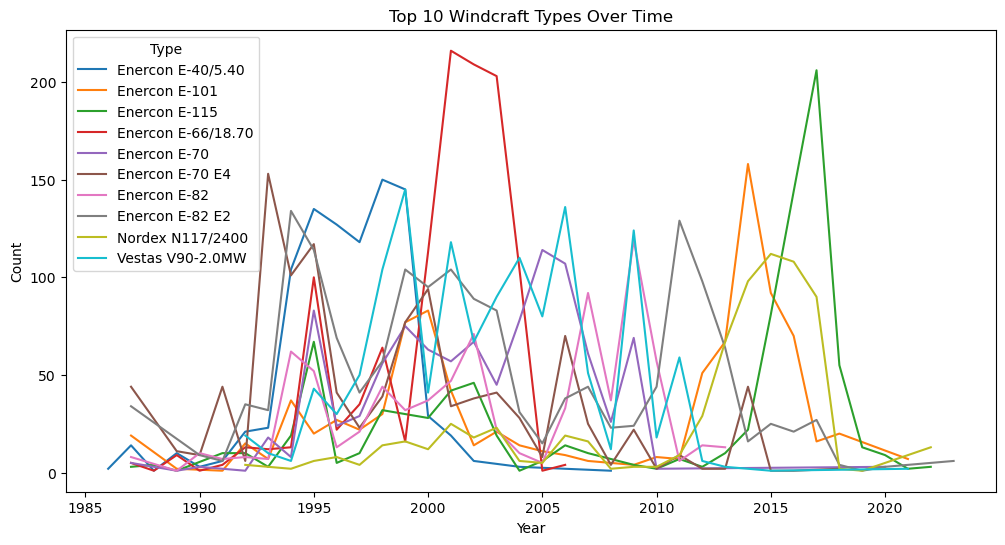

In [16]:
# Identify the top 10 types by total count
top_types = df_exploded.groupby('type')['count'].sum().nlargest(10).index

# Filter the dataset for only the top 10 types
filtered_data = df_exploded[df_exploded['type'].isin(top_types)]

# Group by type and year
trend_data = filtered_data.groupby(['Anfangjahr', 'type'])['count'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x='Anfangjahr', y='count', hue='type')
plt.title('Top 10 Windcraft Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()

### Interpretation: the year here is the year of opening of Windpark, it doesn't mean that the type of Windcrafts shown was exploited already in the same year, it could be installed later, this plot reflects the trends of the usage of particluar crafts during the time. If we see Enercon E115 in some early WindParks, like in the year 1995, it doesn't mean it was exploted already at that time, it means, that the Windpark was modernised and trubines were exchanged und added.

### It is notable that already not Enercon-115 , not Nordex N117/2400 are not up to date, later I will study the most modern turbine types and they application trends.

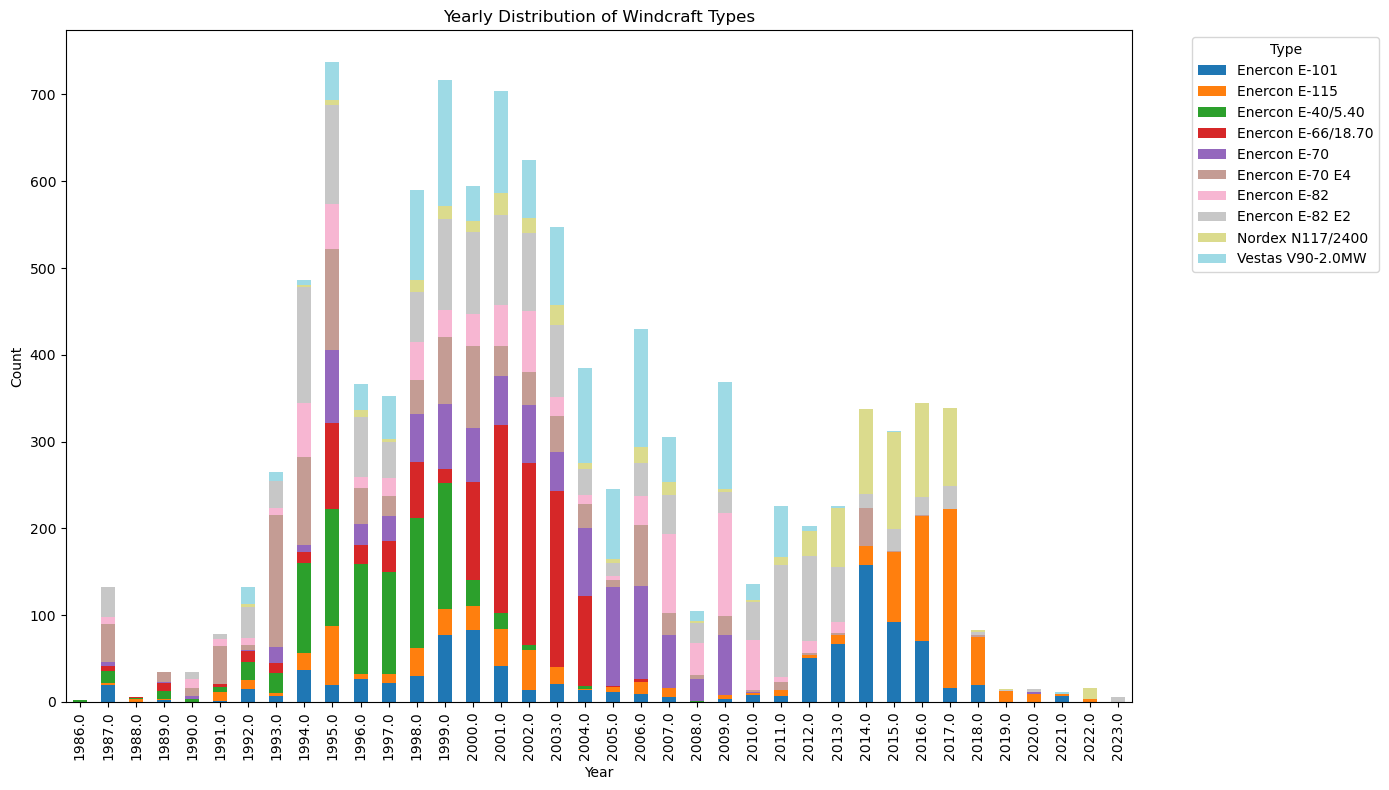

In [17]:
# Group by year and type
yearly_data = filtered_data.groupby(['Anfangjahr', 'type'])['count'].sum().unstack(fill_value=0)

# Plot
yearly_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Yearly Distribution of Windcraft Types')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Actually, show the waves of some types of turbines during the time, how the came to the peak and then were exchanged by the more modern and so on. Interesting that ENercon E101 - was built quite actively at the later times as well - look at this peak in 2012 - 2016, I have to read about this phenomenon.

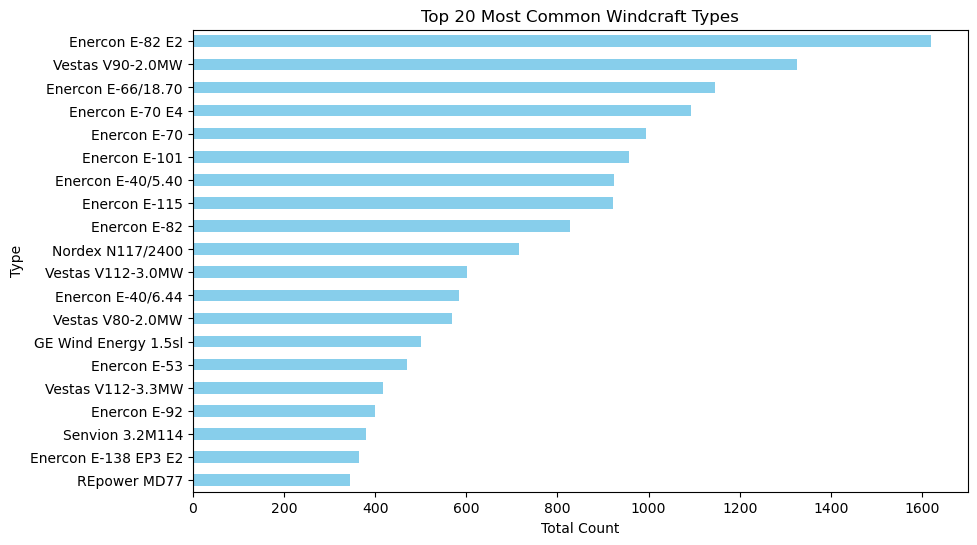

In [18]:
# Aggregate total counts for each type
type_totals = df_exploded.groupby('type')['count'].sum().sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
type_totals.plot(kind='barh', color='skyblue')
plt.title('Top 20 Most Common Windcraft Types')
plt.xlabel('Total Count')
plt.ylabel('Type')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

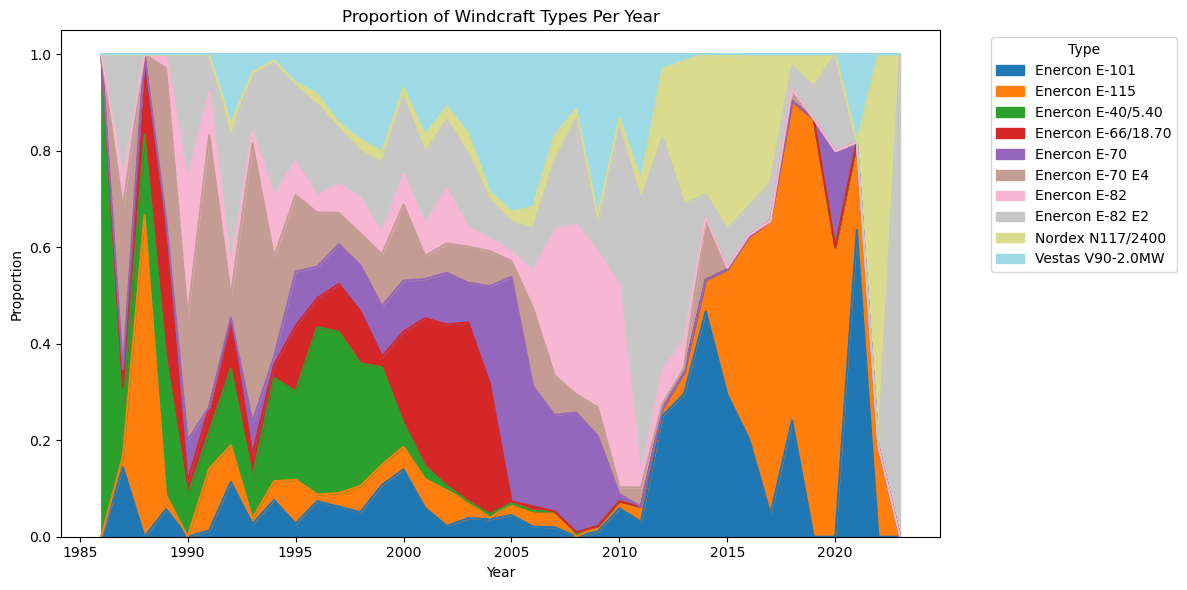

In [19]:
# Group by year and type, calculate total counts for each year
proportion_data = filtered_data.groupby(['Anfangjahr', 'type'])['count'].sum().unstack(fill_value=0)
proportion_data = proportion_data.div(proportion_data.sum(axis=1), axis=0)  # Normalize to proportions

# Plot
proportion_data.plot(kind='area', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Proportion of Windcraft Types Per Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

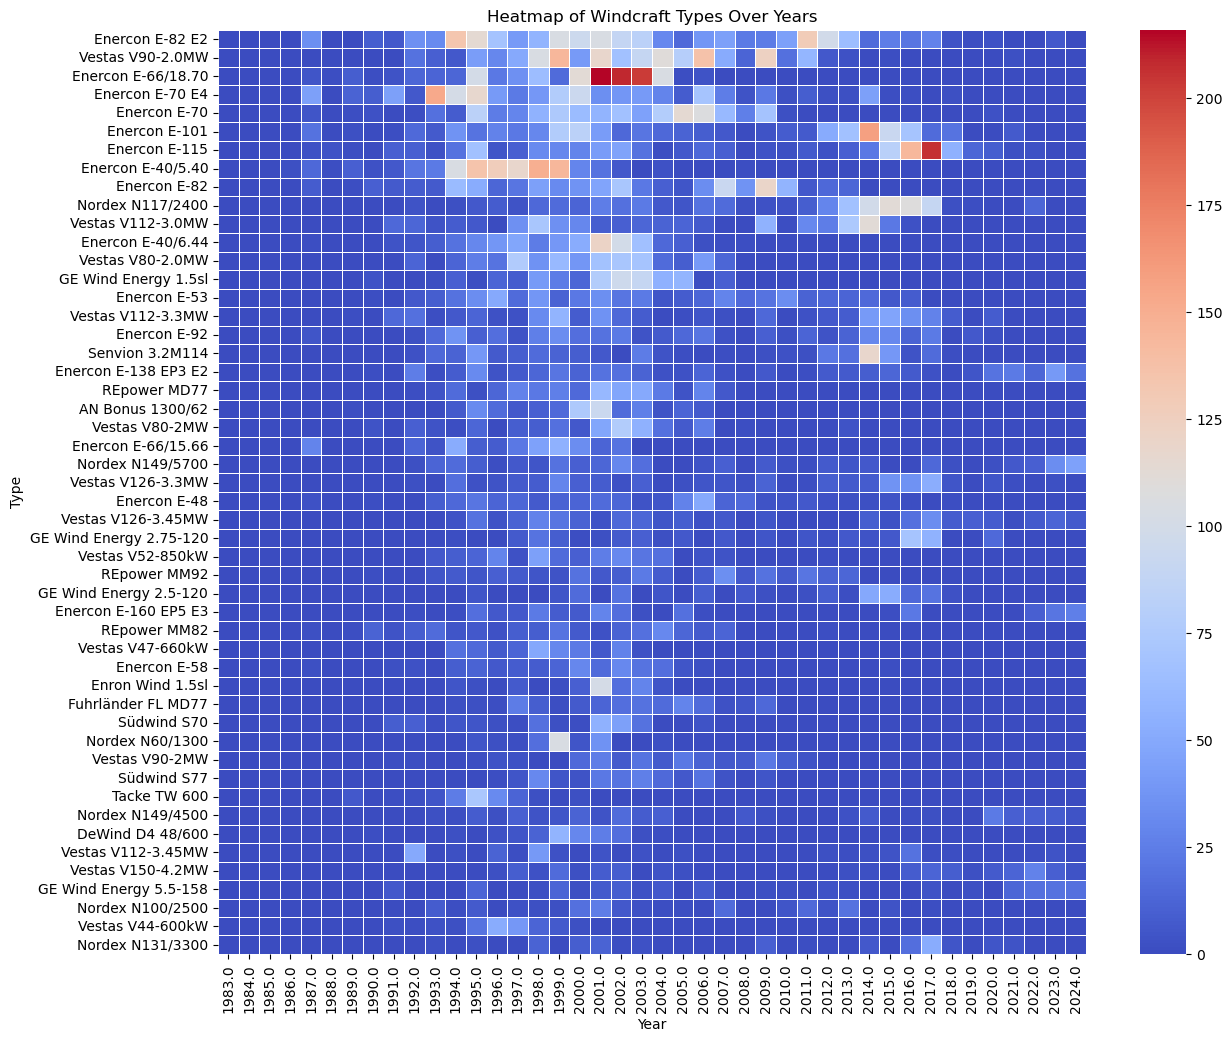

In [20]:
# Create a pivot table
heatmap_data = df_exploded.pivot_table(index='type', columns='Anfangjahr', values='count', aggfunc=np.sum, fill_value=0)

# Filter to top 50 types
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).nlargest(50).index]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Windcraft Types Over Years')
plt.xlabel('Year')
plt.ylabel('Type')
plt.show()

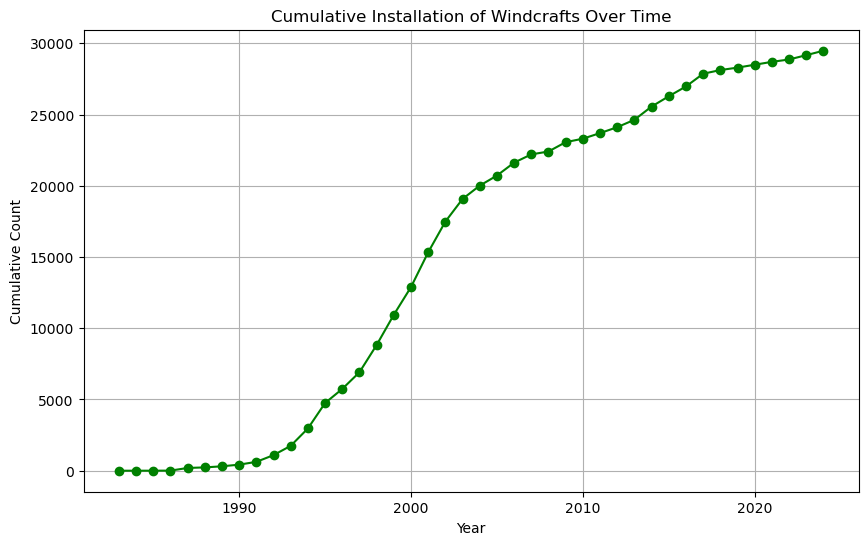

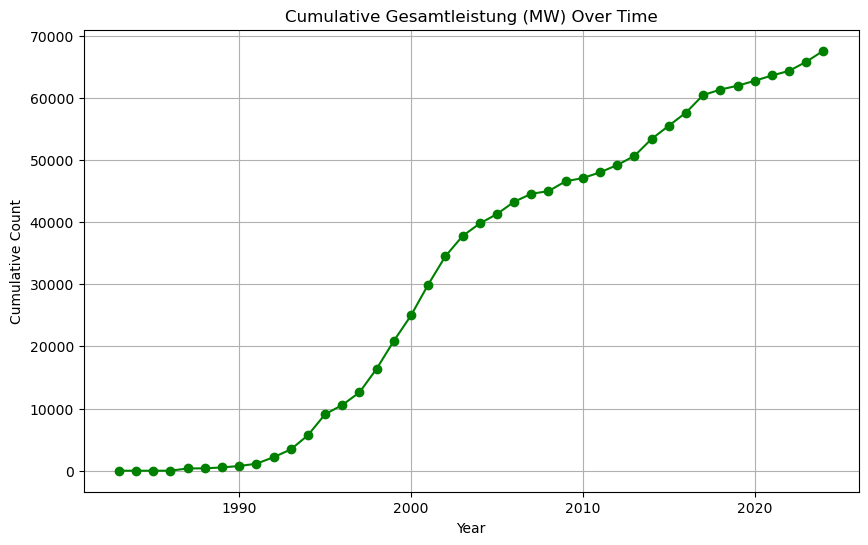

In [74]:
# Group by year and calculate cumulative sum
cumulative_data = df_exploded.groupby('Anfangjahr')['count'].sum().cumsum()

# Plot
plt.figure(figsize=(10, 6))
cumulative_data.plot(kind='line', color='green', marker='o')
plt.title('Cumulative Installation of Windcrafts Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Count')
plt.grid(True)
plt.show()

# Group by year and calculate cumulative sum
cumulative_data = df.groupby('Anfangjahr')['Gesamtleistung (MW)'].sum().cumsum()

# Plot
plt.figure(figsize=(10, 6))
cumulative_data.plot(kind='line', color='green', marker='o')
plt.title('Cumulative Gesamtleistung (MW) Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Count')
plt.grid(True)
plt.show()

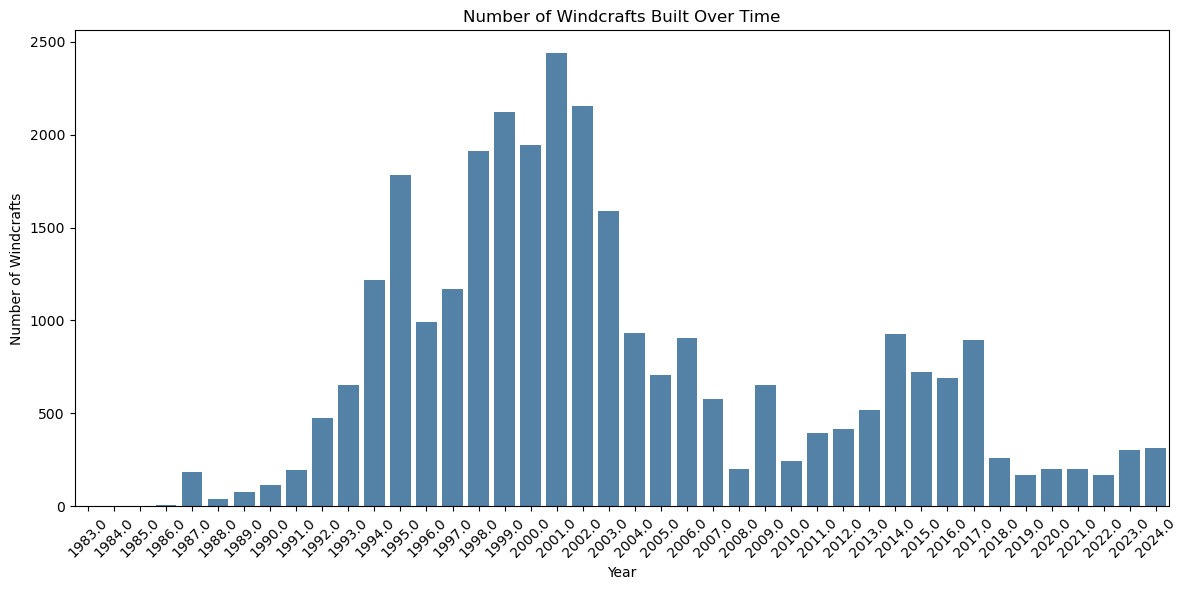

In [22]:
# Count the number of windcrafts built each year
construction_counts = df_exploded.groupby('Anfangjahr')['count'].sum().reset_index()

# Plot the counts
plt.figure(figsize=(12, 6))
sns.barplot(data=construction_counts, x='Anfangjahr', y='count', color='steelblue')
plt.title('Number of Windcrafts Built Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Windcrafts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df_exploded['type'].unique()

array(['Qreon Q82', 'Südwind S70', 'Enercon E-70 E4', 'Reymo DANmark 22',
       'Enercon E-33', 'Nordex N50/800', 'Fuhrländer FL 1000/54',
       'Enercon E-53', 'Enercon E-18', 'Vestas V52-850kW', 'Bonus 150/30',
       'Seewind 20/110', 'NEG Micon NM 82/1500', 'Enercon E-58',
       'Nordex N29/250', 'Enercon E-70', 'REpower MD77',
       'Enercon E-40/6.44', 'Enercon E-40/5.40', 'Tacke TW 600a',
       'Enercon E-138 EP3 E2', 'REpower MM92', 'Enercon E-82',
       'Nordex N149/4500', 'Vestas V136-3.6MW', 'Markham VS45',
       'Südwind S77', 'Micon M300-55', 'Enercon E-138 EP3',
       'Enercon E-66/18.70', 'Enercon E-101', 'Lagerwey LW 18/80',
       'NEG Micon NM 52/900', 'Vestas V90-2.0MW', 'Fuhrländer FL MD77',
       'Nordex N43/600', 'Vestas V162-5.6MW', 'Enercon E-48',
       'Nordex N131/3300', 'Vestas V44-600kW', 'Vestas V136-3.45MW',
       'Vestas V126-3.45MW', 'Senvion MM100', 'Vensys 112/2500',
       'Vensys 120/3000', 'Enercon E-92', 'AN Bonus 1300/62',
       'NEG M

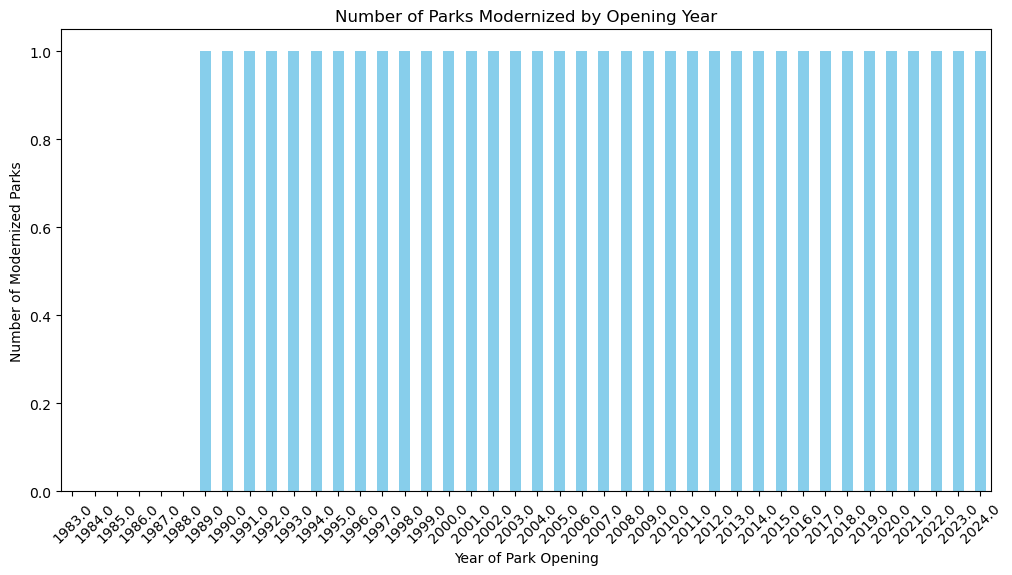

In [24]:
# Define modern windcraft types
modern_types = ['Nordex N163/6800','Vestas V172-7.2MW', 'eno energy eno160-6.0MW', 'Enercon E-160 EP5 E3',
               'GE Wind Energy 5.5-158', 'Siemens Gamesa SG 6.6-170', 'Enercon E-175 EP5','Enercon E-138 EP3 E2',
               'Vestas V162-7.2MW ', 'Enercon E-138 EP3 E3','Enercon E-147 EP5 E1', 'Enercon E-138 EP3',
               'Enercon E-138 EP3 E1', 'Enercon E-115 EP3 E3', 'Enercon E-141 EP4','Siemens Gamesa SG 5.0-132',
                'Enercon E-115 EP3 E3 2.99','Enercon E-126 EP3 4.0', 'Nordex N175/6800', 'Enercon E-147 EP5 E2',
                'Enercon E-126 EP3 3.5','Siemens Gamesa SG 6.6-155', 'Nordex N149/4500','Vestas V162-5.6MW',
                'Vestas V150-5.6MW', 'Vestas V150-4.2MW', 'Vestas V162-6.2MW', 'Nordex N149/5700',
                'Nordex N163/5700', 'eno energy eno152-5.6MW', 'GE Wind Energy 5.5-158','Vestas V162-6.0MW',
                'Nordex N175/6800', 'Enercon E-126 EP8', 'Enercon E-115 EP3', 'Vestas V162-7.2MW',
                'Enercon E-115 EP3 E4', 'Siemens Gamesa SG-6.6-170', 'GE Wind Energy 5.3-158',
                'Nordex N163/7000', 'Enercon E160 EP5 E3', 'GE Wind Energy 6.1-158', 'Enercon E-147 EP5',
                'Enercon E-126 EP3', 'Vestas V162-6.0/6.2MW', 'Enercon E138 EP3 E2', 'Vestas V150-4.0MW',
                'GE Wind Energy 4.8-158', 'eno energy eno140-4.2MW', 'Enercon E-126', 'Enercon E-126 7.5MW',
                'Enercon E-126 7.5', 'Enercon E-147 EP5 E1']  # Add other modern types

# Create a flag for modern windcrafts
df_exploded['is_modern'] = df_exploded['type'].isin(modern_types)

# Group by 'Anfangjahr' and count the number of parks with modern windcrafts
modernization_trends = (
    df_exploded.groupby('Anfangjahr')
    .apply(lambda group: group['is_modern'].any())  # Check if any modern windcraft exists
    .reset_index(name='contains_modern')
)

# Count the number of parks modernized for each year
modernization_counts = modernization_trends.groupby('Anfangjahr')['contains_modern'].sum()

# Plot modernization trends
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
modernization_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Parks Modernized by Opening Year')
plt.xlabel('Year of Park Opening')
plt.ylabel('Number of Modernized Parks')
plt.xticks(rotation=45)
plt.show()

In [25]:
print(df_exploded[['type', 'is_modern']].value_counts())

type                       is_modern
Enercon E-82 E2            False        411
Enercon E-40/5.40          False        382
Enercon E-40/6.44          False        271
Enercon E-66/18.70         False        267
Vestas V90-2.0MW           False        242
                                       ... 
HSW 250                    False          1
Gamesa G97                 False          1
Gamesa G90-2.0MW           False          1
Gamesa G128-4.5MW          False          1
windwise maxcap 141-2.3MW  False          1
Name: count, Length: 514, dtype: int64


In [26]:
# Inspect groups for specific years
example_year = 2000  # Replace with a year from the dataset
print(df_exploded[df_exploded['Anfangjahr'] == example_year])

                             Name_x  \
19          Windkraftanlage Glatten   
20    Windkraftanlage Grüner Heiner   
49          Windkraftanlage Zimmern   
66      Windkraftanlagen Nesselbach   
70       Windkraftanlagen Suppingen   
...                             ...   
4229  Windpark Werbig-Hohengörsdorf   
4229  Windpark Werbig-Hohengörsdorf   
4229  Windpark Werbig-Hohengörsdorf   
4229  Windpark Werbig-Hohengörsdorf   
4229  Windpark Werbig-Hohengörsdorf   

                                                Baujahr  Anfangjahr  \
19                                                2000,      2000.0   
20                                                2000,      2000.0   
49                                                2000,      2000.0   
66                                           2000,2002,      2000.0   
70                                                2000,      2000.0   
...                                                 ...         ...   
4229  2000, 200,1 20,02 2,007 ,201

In [27]:
df_exploded['modern_count'] = df_exploded.groupby('Anfangjahr')['is_modern'].transform('sum')
modernization_trends = df_exploded.groupby('Anfangjahr').apply(lambda group: group['modern_count'].sum() > 5)

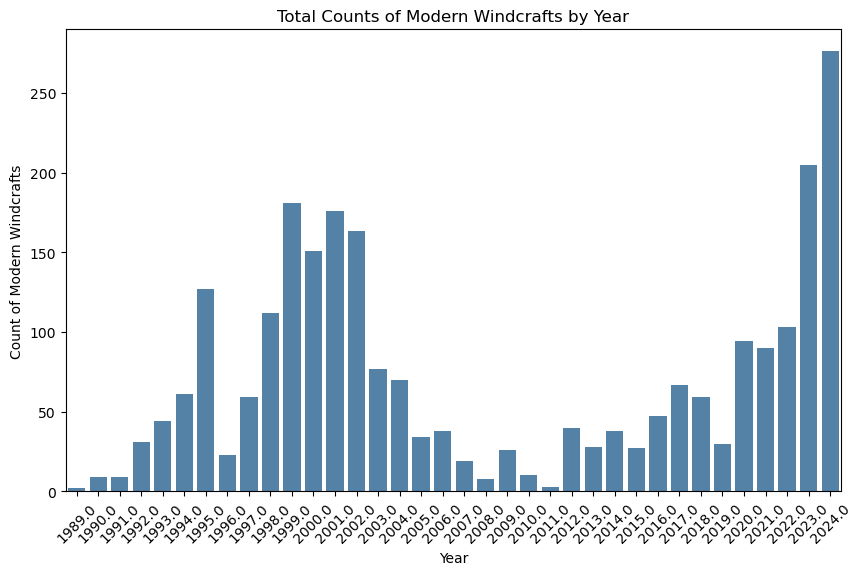

In [28]:
# Aggregate total counts of modern windcrafts per year
modernization_counts = (
    df_exploded[df_exploded['is_modern']]
    .groupby('Anfangjahr')['count']
    .sum()
    .reset_index()
)

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(data=modernization_counts, x='Anfangjahr', y='count', color='steelblue')
plt.title('Total Counts of Modern Windcrafts by Year')
plt.xlabel('Year')
plt.ylabel('Count of Modern Windcrafts')
plt.xticks(rotation=45)
plt.show()

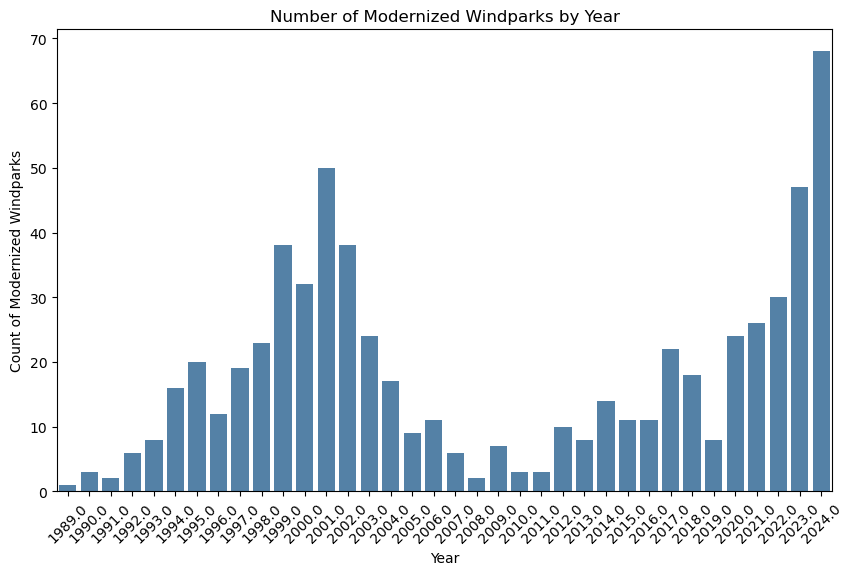

In [29]:
# Identify windparks containing modern windcrafts
modernized_windparks = (
    df_exploded[df_exploded['is_modern']]
    .groupby('Name_x')
    .agg({'Anfangjahr': 'first'})  # Preserve the start year for the park
    .reset_index()
)

# Count the number of modernized windparks by year
modernized_counts = (
    modernized_windparks.groupby('Anfangjahr')
    .size()
    .reset_index(name='count')
)

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(data=modernized_counts, x='Anfangjahr', y='count', color='steelblue')
plt.title('Number of Modernized Windparks by Year')
plt.xlabel('Year')
plt.ylabel('Count of Modernized Windparks')
plt.xticks(rotation=45)
plt.show()

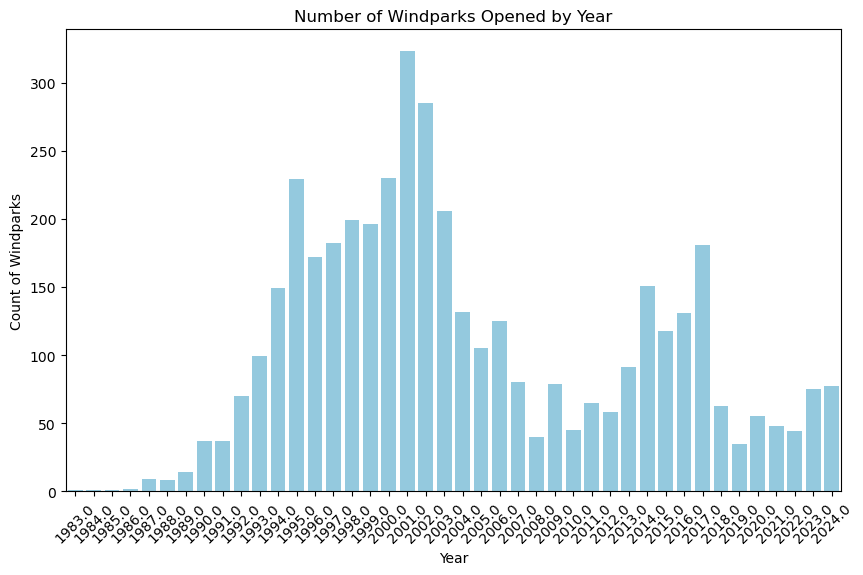

In [30]:
# Count all windparks by their starting year (Anfangjahr)
all_windparks = (
    df_exploded.groupby('Name_x')
    .agg({'Anfangjahr': 'first'})  # Preserve the start year for the park
    .reset_index()
)

# Count the number of windparks by year
all_windparks_counts = (
    all_windparks.groupby('Anfangjahr')
    .size()
    .reset_index(name='count')
)

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(data=all_windparks_counts, x='Anfangjahr', y='count', color='skyblue')
plt.title('Number of Windparks Opened by Year')
plt.xlabel('Year')
plt.ylabel('Count of Windparks')
plt.xticks(rotation=45)
plt.show()

In [31]:
# Filter the DataFrame to only include modern turbine types
modern_turbines_df = df_exploded[df_exploded['type'].isin(modern_types)]

# Count the occurrences of each modern turbine type
top_15_modern_turbines = (
    modern_turbines_df['type']
    .value_counts()
    .head(15)  # Get the top 15
    .reset_index()
    .rename(columns={'index': 'Turbine Type', 'type': 'Count'})
)

# Display the top 15 modern turbines
print(top_15_modern_turbines)

# Plot the data
import plotly.express as px

fig = px.bar(
    top_15_modern_turbines,
    x='count',
    y='Count',
    title='Top 15 Modern Turbine Models by Frequency',
    labels={'Turbine Type': 'Modern Turbine Type', 'Count': 'Number of Turbines'},
    height=600
)

# Rotate x-axis labels for better readability
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()

                     Count  count
0     Enercon E-138 EP3 E2    132
1         Nordex N149/5700     96
2     Enercon E-160 EP5 E3     55
3         Nordex N149/4500     50
4        Vestas V150-4.2MW     49
5   GE Wind Energy 5.5-158     47
6        Vestas V150-5.6MW     47
7     Enercon E-115 EP3 E3     45
8        Enercon E-141 EP4     36
9    Enercon E-126 EP3 4.0     30
10       Vestas V162-6.0MW     30
11        Nordex N163/6800     28
12       Vestas V162-5.6MW     26
13        Nordex N163/5700     23
14       Vestas V162-6.2MW     22


In [32]:
# Filter the DataFrame to include only modern turbine types
modern_turbines_df = df_exploded[df_exploded['type'].isin(modern_types)]

# Group by Bundesland and turbine type, and count occurrences
bundesland_turbine_counts = (
    modern_turbines_df.groupby(['NUTS 1.1', 'type'])
    .size()
    .reset_index(name='Count')
)

# Find the top 15 turbines for each Bundesland
top_15_by_bundesland = (
    bundesland_turbine_counts.groupby('NUTS 1.1', group_keys=False)
    .apply(lambda group: group.nlargest(15, 'Count'))  # Get the top 15 for each Bundesland
    .reset_index(drop=True)
)

# Display the results
print(top_15_by_bundesland)

# Visualization
import plotly.express as px

fig = px.bar(
    top_15_by_bundesland,
    x='NUTS 1.1',
    y='Count',
    color='type',
    title='Top 15 Modern Turbines by Bundesland',
    labels={'NUTS 1.1': 'Bundesland', 'type': 'Modern Turbine Type', 'Count': 'Number of Turbines'},
    height=700
)

# Customize the layout
fig.update_layout(barmode='stack', xaxis_tickangle=-45)

# Show the plot
fig.show()

              NUTS 1.1                     type  Count
0    Baden-Württemberg     Enercon E-138 EP3 E2     15
1    Baden-Württemberg     Enercon E-160 EP5 E3      4
2    Baden-Württemberg         Nordex N149/4500      4
3    Baden-Württemberg     Enercon E-115 EP3 E3      3
4    Baden-Württemberg        Enercon E-138 EP3      2
..                 ...                      ...    ...
161          Thüringen         Nordex N149/4500      1
162          Thüringen         Nordex N163/5700      1
163          Thüringen        Vestas V162-6.0MW      1
164          Thüringen        Vestas V162-6.2MW      1
165          Thüringen  eno energy eno152-5.6MW      1

[166 rows x 3 columns]


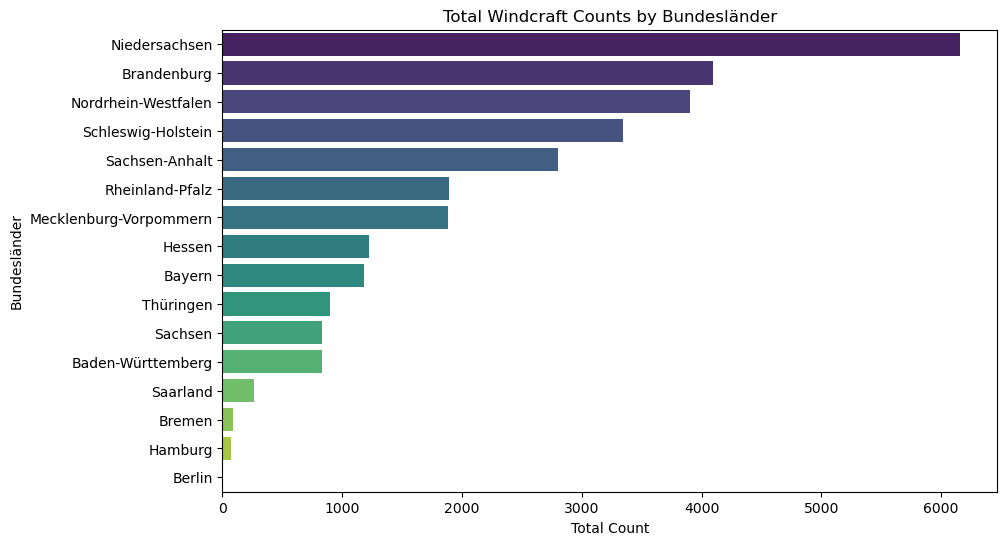

In [33]:
# Aggregate counts by Bundesländer
bundesland_counts = df.groupby('NUTS 1.1')['Anzahl'].sum().sort_values(ascending=False)

# Bar plot for counts by Bundesländer
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=bundesland_counts.values, y=bundesland_counts.index, palette='viridis')
plt.title('Total Windcraft Counts by Bundesländer')
plt.xlabel('Total Count')
plt.ylabel('Bundesländer')
plt.show()

                  NUTS 1.1                type  count
0        Baden-Württemberg       Enercon E-115   76.0
1                   Bayern    Nordex N117/2400  262.0
2                   Berlin        Enercon E-92    2.0
3              Brandenburg    Vestas V90-2.0MW  576.0
4                   Bremen     Enercon E-82 E2   13.0
5                  Hamburg    Nordex N117/2400   10.0
6                   Hessen       Enercon E-115  117.0
7   Mecklenburg-Vorpommern       Enercon E-101  131.0
8            Niedersachsen  Enercon E-66/18.70  455.0
9      Nordrhein-Westfalen     Enercon E-82 E2  286.0
10         Rheinland-Pfalz     Enercon E-82 E2  160.0
11                Saarland       Enercon E-115   26.0
12                 Sachsen   Enercon E-40/5.40   62.0
13          Sachsen-Anhalt        Enercon E-70  193.0
14      Schleswig-Holstein     Enercon E-70 E4  523.0
15               Thüringen    Vestas V90-2.0MW  122.0


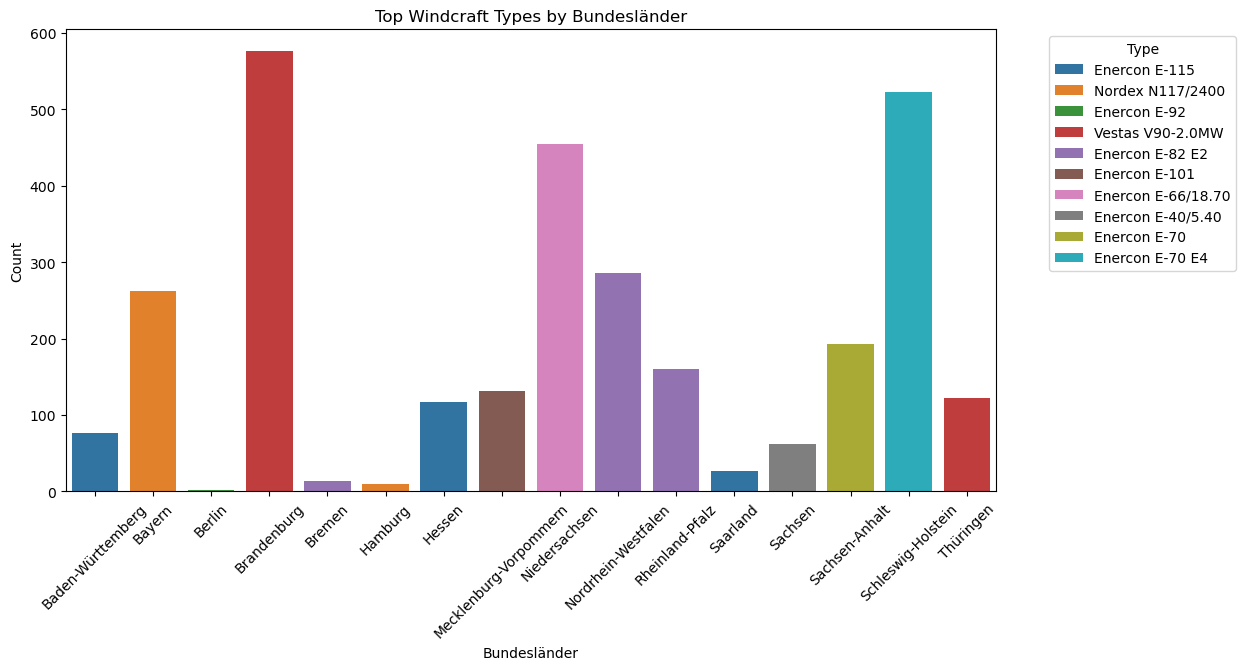

In [34]:
# Find the most common type in each Bundesland
common_type = (
    df_exploded.groupby(['NUTS 1.1', 'type'])['count'].sum()
    .reset_index()
    .sort_values(['NUTS 1.1', 'count'], ascending=[True, False])
)

# Get the top type for each Bundesland
top_type = common_type.groupby('NUTS 1.1').first().reset_index()

print(top_type)

# Bar plot for top windcraft types in each Bundesland
plt.figure(figsize=(12, 6))
sns.barplot(data=top_type, x='NUTS 1.1', y='count', hue='type', dodge=False)
plt.title('Top Windcraft Types by Bundesländer')
plt.xlabel('Bundesländer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

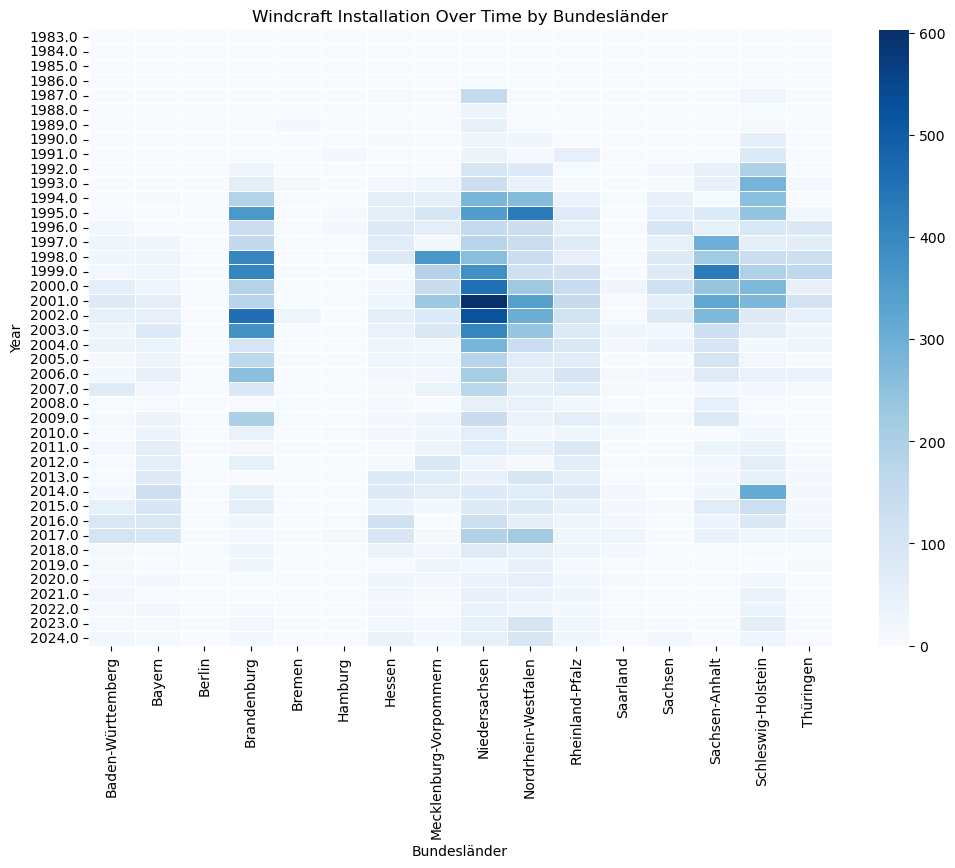

In [35]:
# Group by Bundesländer and Anfangjahr
bundesland_year = df_exploded.groupby(['NUTS 1.1', 'Anfangjahr'])['count'].sum().reset_index()

# Heatmap for distribution over time
heatmap_data = bundesland_year.pivot(index='Anfangjahr', columns='NUTS 1.1', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Blues', linewidths=0.5)
plt.title('Windcraft Installation Over Time by Bundesländer')
plt.xlabel('Bundesländer')
plt.ylabel('Year')
plt.show()

In [36]:
bundesland_year

NUTS 1.1  Anfangjahr  count
0    Baden-Württemberg      1990.0    2.0
1    Baden-Württemberg      1992.0    1.0
2    Baden-Württemberg      1993.0    1.0
3    Baden-Württemberg      1994.0    2.0
4    Baden-Württemberg      1995.0    3.0
..                 ...         ...    ...
447          Thüringen      2016.0   15.0
448          Thüringen      2017.0   24.0
449          Thüringen      2019.0    8.0
450          Thüringen      2023.0    1.0
451          Thüringen      2024.0    3.0

[452 rows x 3 columns]

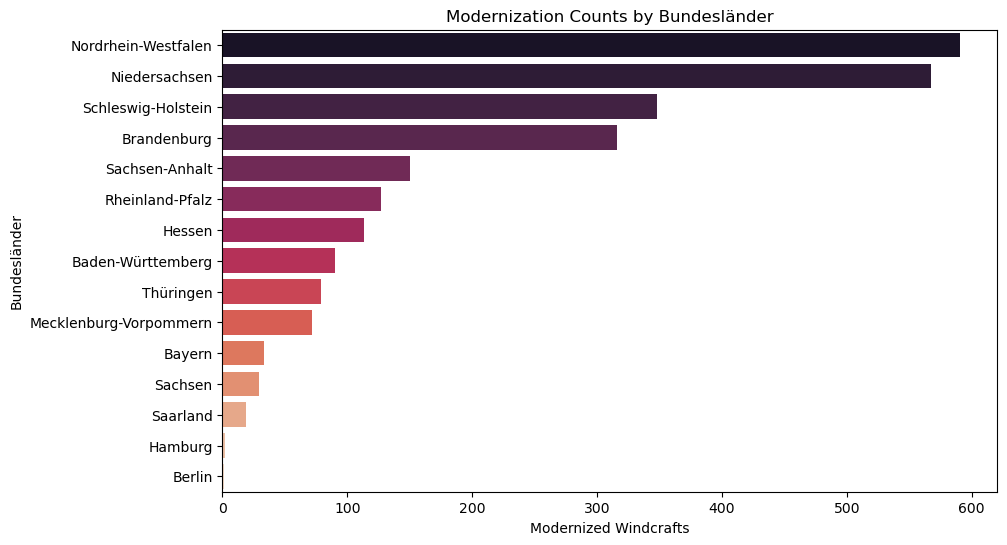

In [37]:
# Aggregate modernization counts by Bundesländer
modernization_counts = df_exploded[df_exploded['is_modern']].groupby('NUTS 1.1')['count'].sum().sort_values(ascending=False)

# Bar plot for modernization by Bundesländer
plt.figure(figsize=(10, 6))
sns.barplot(x=modernization_counts.values, y=modernization_counts.index, palette='rocket')
plt.title('Modernization Counts by Bundesländer')
plt.xlabel('Modernized Windcrafts')
plt.ylabel('Bundesländer')
plt.show()

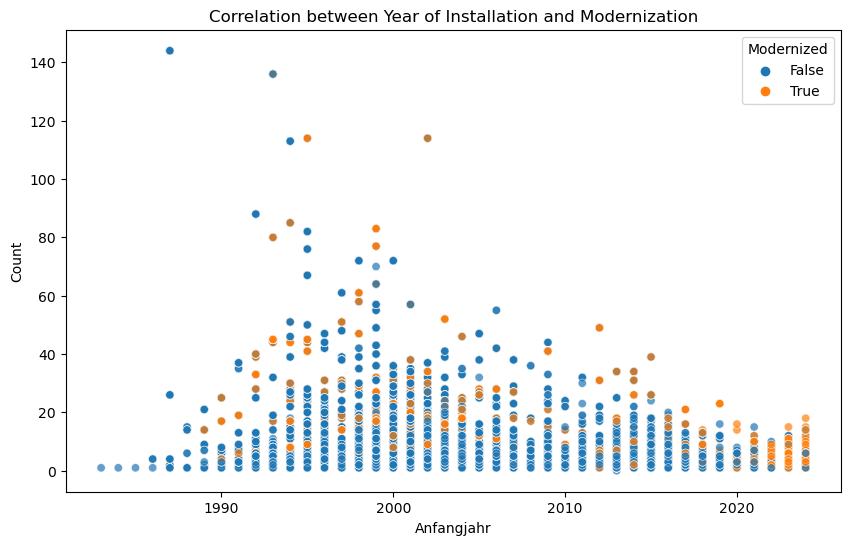

In [38]:
# Scatter plot for year vs modernization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_exploded, x='Anfangjahr', y='Anzahl', hue='is_modern', alpha=0.7)
plt.title('Correlation between Year of Installation and Modernization')
plt.xlabel('Anfangjahr')
plt.ylabel('Count')
plt.legend(title='Modernized')
plt.show()

In [39]:
# Count the most popular turbine type for each year and Bundesland
df_counts = df_exploded.groupby(['NUTS 1.1', 'Anfangjahr', 'type']).size().reset_index(name='Count')

# Identify the most popular turbine for each year and Bundesland
df_most_popular = df_counts.loc[df_counts.groupby(['NUTS 1.1', 'Anfangjahr'])['Count'].idxmax()]

# Create the plot
fig = px.bar(df_most_popular,
             x='NUTS 1.1',
             y='Count',
             color='type',
             title='Most Popular Wind Turbine Type per Bundesland and Year',
             animation_frame='Anfangjahr',
             animation_group='NUTS 1.1',
             labels={'NUTS 1.1': 'Bundesland', 'Count': 'Turbine Count', 'type': 'Turbine Type'},
             height=600)

# Show the plot
fig.show()

In [40]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px

# Define a function to filter and plot for a specific Bundesland
def plot_for_bundesland(bundesland):
    # Filter the DataFrame for the selected Bundesland
    df_filtered = df_most_popular[df_most_popular['NUTS 1.1'] == bundesland]
    # Create the bar plot
    fig = px.bar(
        df_filtered,
        x='Anfangjahr',  # Year on x-axis
        y='Count',  # Count of turbines on y-axis
        color='type',  # Turbine type as color
        title=f'Most Popular Turbine Types in {bundesland} Over the Years',
        labels={'Anfangjahr': 'Year', 'Count': 'Turbine Count', 'type': 'Turbine Type'},
        height=600
    )
    
    # Clear the previous output and show the new plot
    clear_output(wait=True)  # Clear the output area
    display(bundesland_dropdown)  # Redisplay the dropdown widget
    fig.show()  # Show the updated plot

# Create a dropdown widget with unique Bundesland values
bundesland_dropdown = widgets.Dropdown(
    options=df_most_popular['NUTS 1.1'].unique(),
    description='Bundesland:',
    value=df_most_popular['NUTS 1.1'].unique()[0]
)

# Display the plot whenever the dropdown value changes
def on_dropdown_change(change):
    plot_for_bundesland(change['new'])

bundesland_dropdown.observe(on_dropdown_change, names='value')

# Display the dropdown
display(bundesland_dropdown)

# Initial plot
plot_for_bundesland(bundesland_dropdown.value)

Dropdown(description='Bundesland:', options=('Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',…

In [41]:
# Aggregate installed capacity by year and Bundesland
df_capacity = df.groupby(['NUTS 1.1', 'Anfangjahr'])['Gesamtleistung (MW)'].sum().reset_index()
df_capacity.rename(columns={'Gesamtleistung (MW)': 'Total Capacity (MW)'}, inplace=True)

# Create a function for plotting
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_installed_capacity(bundesland):
    # Filter data for the selected Bundesland
    df_filtered = df_capacity[df_capacity['NUTS 1.1'] == bundesland]
    
    # Create the plot
    fig = px.bar(
        df_filtered,
        x='Anfangjahr',
        y='Total Capacity (MW)',
        title=f'Total Installed Capacity in {bundesland} Over the Years',
        labels={'Anfangjahr': 'Year', 'Total Capacity (MW)': 'Installed Capacity (MW)'},
        height=600
    )
    
    # Show the plot
    fig.show()

# Create a dropdown widget for Bundesland selection
bundesland_dropdown = widgets.Dropdown(
    options=df_capacity['NUTS 1.1'].unique(),
    description='Bundesland:',
    value=df_capacity['NUTS 1.1'].unique()[0]
)

def on_capacity_dropdown_change(change):
    clear_output(wait=True)
    display(bundesland_dropdown)
    plot_installed_capacity(change['new'])

bundesland_dropdown.observe(on_capacity_dropdown_change, names='value')

display(bundesland_dropdown)

# Initial plot
plot_installed_capacity(bundesland_dropdown.value)


Dropdown(description='Bundesland:', options=('Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',…

In [42]:
# Import clear_output
#from IPython.display import clear_output

# Define a function to calculate and plot the average turbine power over time
def plot_avg_power_over_time(bundesland):
    # Clear the output
    clear_output(wait=True)
    
    # Display the dropdown again to keep it visible
    display(bundesland_dropdown_avg)
    
    # Filter the original data for the selected Bundesland
    df_filtered = df[df['NUTS 1.1'] == bundesland]
    
    # Calculate the average turbine power per year
    df_avg_power = df_filtered.groupby('Anfangjahr')['Gesamtleistung (MW)'].mean().reset_index()
    df_avg_power.rename(columns={'Gesamtleistung (MW)': 'Average Power (MW)'}, inplace=True)
    
    # Create the line plot
    fig = px.line(
        df_avg_power,
        x='Anfangjahr',  # Year on x-axis
        y='Average Power (MW)',  # Average turbine power on y-axis
        title=f'Average Turbine Power Over Time in {bundesland}',
        labels={'Anfangjahr': 'Year', 'Average Power (MW)': 'Average Turbine Power (MW)'},
        height=600
    )
    
    # Show the plot
    fig.show()

# Add a new dropdown widget for Average Turbine Power analysis
bundesland_dropdown_avg = widgets.Dropdown(
    options=df['NUTS 1.1'].unique(),
    description='Bundesland:',
    value=df['NUTS 1.1'].unique()[0]
)

# Display the plot whenever the dropdown value changes
def on_avg_dropdown_change(change):
    plot_avg_power_over_time(change['new'])

bundesland_dropdown_avg.observe(on_avg_dropdown_change, names='value')

# Display the dropdown
display(bundesland_dropdown_avg)

# Initial plot
plot_avg_power_over_time(bundesland_dropdown_avg.value)

Dropdown(description='Bundesland:', options=('Baden-Württemberg', 'Thüringen', 'Schleswig-Holstein', 'Nordrhei…

In [43]:
# Define a function to calculate and plot cumulative power for all Bundesländer
def plot_cumulative_power():
    # Group by year and Bundesland, then sum the turbine power
    df_cumulative = (
        df.groupby(['Anfangjahr', 'NUTS 1.1'])['Gesamtleistung (MW)']
        .sum()
        .groupby(level=1)
        .cumsum()
        .reset_index()
    )
    
    # Rename columns for better understanding
    df_cumulative.rename(
        columns={'Gesamtleistung (MW)': 'Cumulative Power (MW)', 'NUTS 1.1': 'Bundesland'},
        inplace=True
    )
    
    # Create a line plot with animation over time
    fig = px.line(
        df_cumulative,
        x='Anfangjahr',  # Year on x-axis
        y='Cumulative Power (MW)',  # Cumulative power on y-axis
        color='Bundesland',  # Different lines for each Bundesland
        title='Cumulative Turbine Power Over Time by Bundesland',
        labels={'Anfangjahr': 'Year', 'Cumulative Power (MW)': 'Cumulative Turbine Power (MW)'},
        height=600
    )
    
    # Show the plot
    fig.show()

# Call the function to display the plot
plot_cumulative_power()

In [44]:
# Calculate the yearly additions
def plot_yearly_turbine_additions():
    # Group by year and Bundesland to count the number of turbines installed each year
    df_yearly_additions = df_exploded.groupby(['Anfangjahr', 'NUTS 1.1']).size().reset_index(name='Additions')
    
    # Create a bar plot
    fig = px.bar(
        df_yearly_additions,
        x='Anfangjahr',
        y='Additions',
        color='NUTS 1.1',
        title='Yearly Turbine Additions by Bundesland',
        labels={'Anfangjahr': 'Year', 'Additions': 'Number of Turbines', 'NUTS 1.1': 'Bundesland'},
        height=600
    )
    
    # Show the plot
    fig.show()

# Call the function to display the plot
plot_yearly_turbine_additions()

In [45]:
manufacturer_mapping=({
    'Micon': 'Micon',
    'REPower': 'Senvion',
    'Lagerwey': 'Enercon',
    'FWT': 'Fuhrländer',
    'Siemens': 'Siemens',  # Differentiate from Siemens Gamesa if needed
    'AREVA': 'AREVA',
    'blu': 'Bluenergy',
    'GE': 'GE',
    'Wentis': 'Wentis',  # Add details if identified
    'Stampa': 'Stampa',  # Placeholder until clarified
    'Euroturbine': 'Euroturbine',  # Placeholder
    'Darwin': 'Darwin',  # Placeholder
    'BARD': 'BARD',
    'Jacobs': 'Jacobs',
    'Adwen': 'Adwen',
    'Fuhrländer': 'Fuhrländer',
    'Proton': 'Proton',  # Placeholder
    'Norton': 'Norton',
    "Enercon": "Enercon",
    "Vestas": "Vestas",
    "GE": "General Electric",
    "Siemens": "Siemens Gamesa",
    "Nordex": "Nordex",
    "Suzlon": "Suzlon",
    'Südwind':'Sudwind',
    "Senvion": "Senvion",
    "Mingyang": "Mingyang",
    "Goldwind": "Goldwind",
    "Gamesa": "Siemens Gamesa", 
    'eno':'ENO',
    'Vensys': 'Vensys',
    'Qreon': 'Qreon',
    'DeWind': 'DeWind',
    'Max-Wyn': 'Max-Wyn',
    'Nordtank': 'Nordtank',
    'Leitwind': 'Leitwind',
    'AN Bonus': 'Bonus',
    'Krogman': 'Krogman',
    'Awinco': 'Awinco',
    'Wind World': 'Wind World',
    'Husumer': 'Husumer',
    'BWU': 'BWU',
    'Tacke': 'Tacke',
    'Seewind': 'Seewind',
    'electrOmat': 'electrOmat',
    'G Engineering': 'General Electric',  # Likely GE
    'Markham': 'Markham',
    'Bonus': 'Bonus',  # Matches AN Bonus
    'Reymo': 'Reymo',
    'Frisia': 'Frisia',
    'HSW': 'HSW',
    'WTN': 'WTN',
    'MAN Aeroman': 'MAN Aeroman',
    'Amperax': 'Amperax',
    'SWT': 'Siemens',  # Commonly used for Siemens Wind Turbines
    'Euron Wind': 'Euron Wind',
    'Schütz': 'Schütz',
    'Kenersis': 'Kenersis',
    'windwise': 'WindWise',
    'Pfleiderer PWE': 'Pfleiderer PWE',
    'Solutions 4 Energy': 'Solutions 4 Energy',
    'Wind to Energy': 'Wind to Energy',
    'Adwen': 'Adwen',
    'Northern Power NPS': 'Northern Power Systems'

    # Placeholder
})

# Function to extract manufacturer with error handling for None/NaN
def extract_manufacturer(turbine_type):
    if pd.isnull(turbine_type):  # Check if value is None or NaN
        return None
    for key, manufacturer in manufacturer_mapping.items():
        if key.lower() in turbine_type.lower():
            return manufacturer
    return None  # Return None if no match is found

# Apply function to create a new column
df_exploded['Manufacturer'] = df_exploded['type'].apply(extract_manufacturer)

# Display the updated DataFrame
print(df_exploded)

                                     Name_x            Baujahr  Anfangjahr  \
0       Forschungswindkraftanlage RedoxWind              2017,      2017.0   
1          Windkraftanlage Alexanderschanze              2003,      2003.0   
2                Windkraftanlage Alpirsbach         1999,2013,      1999.0   
3                  Windkraftanlage Auenberg              1990,      1990.0   
4     Windkraftanlage auf dem Hohwartsattel              1992,      1992.0   
...                                     ...                ...         ...   
4248                    Windpark Zehlendorf              2003,      2003.0   
4249                  Windpark Zitz-Warchau              2003,      2003.0   
4250                        Windpark Zossen  2002, 200,3 20,04      2002.0   
4250                        Windpark Zossen  2002, 200,3 20,04      2002.0   
4250                        Windpark Zossen  2002, 200,3 20,04      2002.0   

      Gesamtleistung (MW)  Anzahl                      Ort Land

In [46]:
# Get the top manufacturers
top_manufacturers = df_exploded['Manufacturer'].value_counts()

print(top_manufacturers)

Manufacturer
Enercon                   3831
Vestas                    1654
Nordex                     841
Senvion                    567
General Electric           351
Micon                      259
Bonus                      226
Tacke                      209
Sudwind                    127
Siemens Gamesa             125
Fuhrländer                 119
DeWind                     105
Vensys                      64
Nordtank                    62
ENO                         53
Seewind                     26
Wind World                  23
Jacobs                      15
Frisia                      11
HSW                         10
Krogman                      7
BWU                          6
WTN                          5
Husumer                      5
Pfleiderer PWE               5
Euroturbine                  4
Wind to Energy               3
MAN Aeroman                  2
BARD                         2
Leitwind                     2
Max-Wyn                      2
Adwen                     

In [47]:
# Calculate the top manufacturers by installed capacity in each region
def plot_top_manufacturers():
    # Group by Bundesland and Manufacturer, summing the installed capacities
    df_top_manufacturers = (
        df_exploded.groupby(['NUTS 1.1', 'Manufacturer'])['Gesamtleistung (MW)']
        .sum()
        .reset_index()
    )

    # Find the top manufacturer for each Bundesland
    df_top_manufacturers = df_top_manufacturers.loc[
        df_top_manufacturers.groupby('NUTS 1.1')['Gesamtleistung (MW)'].idxmax()
    ]

    # Create a bar plot
    fig = px.bar(
        df_top_manufacturers,
        x='NUTS 1.1',
        y='Gesamtleistung (MW)',
        color='Manufacturer',
        title='Top Manufacturers by Installed Capacity in Each Region',
        labels={'NUTS 1.1': 'Bundesland', 'Turbine Power (MW)': 'Installed Capacity (MW)'},
        height=600
    )

    # Show the plot
    fig.show()

# Call the function to display the plot
plot_top_manufacturers()

In [81]:
def plot_top_10_manufacturers_by_count():
    # Count turbines by Bundesland and Manufacturer
    df_manufacturer_count = (
        df_exploded.groupby(['NUTS 1.1', 'Manufacturer'])
        .size()
        .reset_index(name='Turbine Count')
    )

    # Sort within each Bundesland to get the top 10 manufacturers
    df_manufacturer_count = (
        df_manufacturer_count.sort_values(['NUTS 1.1', 'Turbine Count'], ascending=[True, False])
        .groupby('NUTS 1.1')
        .head(10)
    )

    # Create a bar plot
    fig = px.bar(
        df_manufacturer_count,
        x='NUTS 1.1',
        y='Turbine Count',
        color='Manufacturer',
        title='Top 10 Manufacturers by Turbine Count in Each Region',
        labels={'NUTS 1.1': 'Bundesland', 'Turbine Count': 'Number of Turbines'},
        height=600
    )

    # Show the plot
    fig.show()

# Call the function
plot_top_10_manufacturers_by_count()

In [78]:
def plot_top_manufacturers_overall():
    # Count turbines by Manufacturer
    df_top_manufacturers_overall = (
        df_exploded['Manufacturer']
        .value_counts()
        .head(10)
        .reset_index()
        .rename(columns={'index': 'Manufacturer', 'Manufacturer': 'Turbine Count'})
    )

    # Create a bar plot
    fig = px.bar(
        df_top_manufacturers_overall,
        x='Turbine Count',
        y='count',
        title='Top 10 Manufacturers Overall',
        labels={'Turbine Count': 'Number of Turbines'},
        height=600
    )

    # Show the plot
    fig.show()

# Call the function
plot_top_manufacturers_overall()

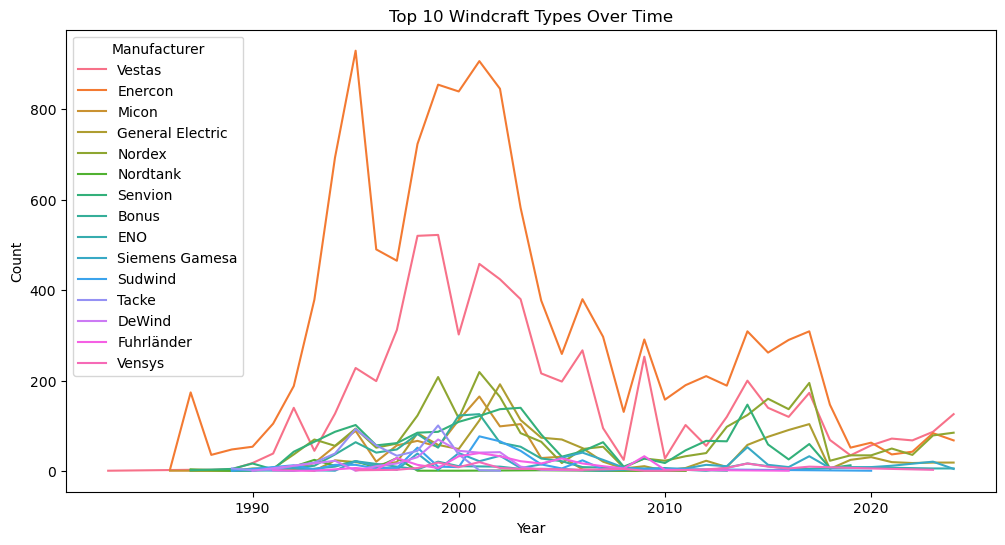

In [50]:
# Identify the top 10 types by total count
top_manu = df_exploded.groupby('Manufacturer')['count'].sum().nlargest(15).index

# Filter the dataset for only the top 10 types
filtered_data = df_exploded[df_exploded['Manufacturer'].isin(top_manu)]

# Group by type and year
trend_data = filtered_data.groupby(['Anfangjahr', 'Manufacturer'])['count'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x='Anfangjahr', y='count', hue='Manufacturer')
plt.title('Top 10 Windcraft Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Manufacturer')
plt.show()

## What about the manufacturer of the most modern turbines:

In [51]:
df_exploded['is_modern'].value_counts()

is_modern
False    7983
True      844
Name: count, dtype: int64

In [52]:
modern_types=df_exploded.loc[df_exploded['is_modern']==True]

In [53]:
def plot_top_manufacturers_overall_modern():
    # Count turbines by Manufacturer
    df_top_manufacturers_overall_modern = (
        modern_types['Manufacturer']
        .value_counts()
        .head(10)
        .reset_index()
        .rename(columns={'index': 'Manufacturer', 'Manufacturer': 'Turbine Count'})
    )

    # Create a bar plot
    fig = px.bar(
        df_top_manufacturers_overall_modern,
        x='Turbine Count',
        y='count',
        title='Top 10 Modern Manufacturers Overall',
        labels={'Turbine Count': 'Number of Turbines'},
        height=600
    )

    # Show the plot
    fig.show()

# Call the function
plot_top_manufacturers_overall_modern()

In [80]:
def plot_top_manufacturers_overall_modern():
    # Count turbines by Manufacturer
    df_top_manufacturers_overall_modern = (
        modern_types['Manufacturer']
        .value_counts()
        .head(10)
        .reset_index())
   

    # Create a bar plot
    fig = px.bar(
        df_top_manufacturers_overall_modern,
        x='Manufacturer',
        y='count',
        title='Top 10 Modern Manufacturers Overall',
        labels={'Turbine Count': 'Number of Turbines'},
        height=600
    )

    # Show the plot
    fig.show()

# Call the function
plot_top_manufacturers_overall_modern()

In [77]:
def plot_top_10_manufacturers_modern_by_count():
    # Count turbines by Bundesland and Manufacturer
    df_manufacturer_modern_count = (
        modern_types.groupby(['NUTS 1.1', 'Manufacturer'])
        .size()
        .reset_index(name='Turbine Count')
    )

    # Sort within each Bundesland to get the top 10 manufacturers
    df_manufacturer_modern_count = (
        df_manufacturer_modern_count.sort_values(['NUTS 1.1', 'Turbine Count'], ascending=[True, False])
        .groupby('NUTS 1.1')
        .head(10)
    )

    # Create a bar plot
    fig = px.bar(
        df_manufacturer_modern_count,
        x='NUTS 1.1',
        y='Turbine Count',
        color='Manufacturer',
        title='Top 10 Modern Manufacturers by Turbine Count in Each Region',
        labels={'NUTS 1.1': 'Bundesland', 'Turbine Count': 'Number of Turbines'},
        height=600
    )

    # Show the plot
    fig.show()

# Call the function
plot_top_10_manufacturers_modern_by_count()

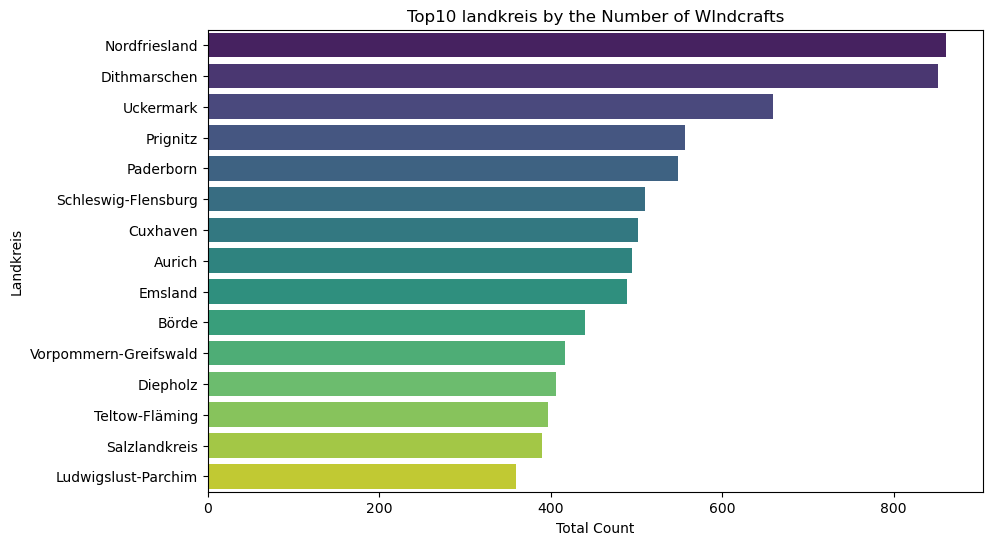

In [55]:
# Aggregate counts by Bundesländer
landkreis_counts = df.groupby('Name_y')['Anzahl'].sum().sort_values(ascending=False).head(15)



plt.figure(figsize=(10, 6))
sns.barplot(x=landkreis_counts.values, y=landkreis_counts.index, palette='viridis')
plt.title('Top10 landkreis by the Number of WIndcrafts')
plt.xlabel('Total Count')
plt.ylabel('Landkreis')
plt.show()

In [56]:
# Extract Name_y (regions) as a list
name_y_list = landkreis_counts.index.tolist()

# Display the list
print(name_y_list)

['Nordfriesland', 'Dithmarschen', 'Uckermark', 'Prignitz', 'Paderborn', 'Schleswig-Flensburg', 'Cuxhaven', 'Aurich', 'Emsland', 'Börde', 'Vorpommern-Greifswald', 'Diepholz', 'Teltow-Fläming', 'Salzlandkreis', 'Ludwigslust-Parchim']


In [57]:
# Filter for top regions
landkreis_counts_top = df_exploded[
    df_exploded['Name_y'].isin(name_y_list)]


# Visualize the top regions
fig = px.bar(
    landkreis_counts_top.sort_values(by='count', ascending= False),
    x='Name_y',
    y='count',
    color='Manufacturer',
    title='Turbines by Manufacturer in Top 15 Regions',
    labels={'Name_y': 'Region (Landkreis)', 'count': 'Number of Modern Turbines'},
    height=600
)

fig.show()

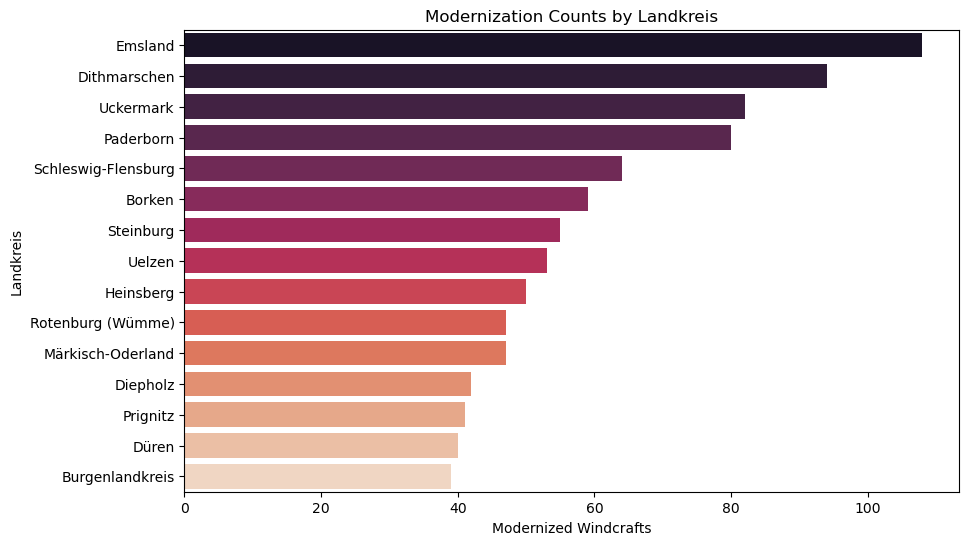

In [58]:
# Aggregate modernization counts by Bundesländer
modernization_counts = df_exploded[df_exploded['is_modern']].groupby('Name_y')['count'].sum().sort_values(ascending=False).head(15)

# Bar plot for modernization by Bundesländer
plt.figure(figsize=(10, 6))
sns.barplot(x=modernization_counts.values, y=modernization_counts.index, palette='rocket')
plt.title('Modernization Counts by Landkreis')
plt.xlabel('Modernized Windcrafts')
plt.ylabel('Landkreis')
plt.show()

In [59]:
modernization_counts

Name_y
Emsland                108.0
Dithmarschen            94.0
Uckermark               82.0
Paderborn               80.0
Schleswig-Flensburg     64.0
Borken                  59.0
Steinburg               55.0
Uelzen                  53.0
Heinsberg               50.0
Rotenburg (Wümme)       47.0
Märkisch-Oderland       47.0
Diepholz                42.0
Prignitz                41.0
Düren                   40.0
Burgenlandkreis         39.0
Name: count, dtype: float64

In [60]:
# Extract Name_y (regions) as a list
name_y_list = modernization_counts.index.tolist()

# Display the list
print(name_y_list)

['Emsland', 'Dithmarschen', 'Uckermark', 'Paderborn', 'Schleswig-Flensburg', 'Borken', 'Steinburg', 'Uelzen', 'Heinsberg', 'Rotenburg (Wümme)', 'Märkisch-Oderland', 'Diepholz', 'Prignitz', 'Düren', 'Burgenlandkreis']


In [61]:
# Filter for top regions
modernization_counts_top = modern_types[
    modern_types['Name_y'].isin(name_y_list)
]

# Visualize the top regions
fig = px.bar(
    modernization_counts_top.sort_values(by='count', ascending= False),
    x='Name_y',
    y='count',
    color='Manufacturer',
    title='Modern Turbines by Manufacturer in Top 15 Regions',
    labels={'Name_y': 'Region (Landkreis)', 'count': 'Number of Modern Turbines'},
    height=600
)

fig.show()

In [62]:
 modernization_counts_top

Name_x  \
302              Windkraftanlage Albersdorf Süd   
308            Windkraftanlagen Bondelum-Ipland   
378   Windkraftanlagen Ottenbüttel-Westermühlen   
379                     Windkraftanlagen Oxlund   
416         Windpark Barlt-Busenwurth-Gudendorf   
...                                         ...   
4228                     Windpark Welsow-Kerkow   
4228                     Windpark Welsow-Kerkow   
4240         Windpark Wölsi­ckendorf-Wollenberg   
4240         Windpark Wölsi­ckendorf-Wollenberg   
4245                   Windpark Wulkow-Trebnitz   

                                         Baujahr  Anfangjahr  \
302                                        2022,      2022.0   
308                                        2023,      2023.0   
378                                        2020,      2020.0   
379                                   2018,2020,      2018.0   
416                                        2023,      2023.0   
...                                          ...         ...   
4228                     2002, 201,7 20,21 2,022      2002.0   
4228                     2002, 201,7 20,21 2,022      2002.0   
4240  1999, 200,9 20,10 2,011 ,2019, 202,0 20,21      1999.0   
4240  1999, 200,9 20,10 2,011 ,2019, 202,0 20,21      1999.0   
4245                                       2022,      2022.0   

      Gesamtleistung (MW)  Anzahl                                Ort  \
302                  5.56       1                         Albersdorf   
308                  8.40       2                     BondelumIpland   
378                  8.40       2                        Ottenbüttel   
379                  7.20       2                             Oxlund   
416                 30.00       5            BarltGudendorfGudendorf   
...                   ...     ...                                ...   
4228                35.80       9                      Kerkow Welsow   
4228                35.80       9                      Kerkow Welsow   
4240                46.60      17  Torgelow Wölsickendorf Dannenberg   
4240                46.60      17  Torgelow Wölsickendorf Dannenberg   
4245                37.80       9                    Wulkow Trebnitz   

     Landkreis                        Projektierer / Betreiber  \
302        HEI                                       WP Schlaa   
308         SL                 Ipland Bürgerwind GmbH & Co. KG   
378         IZ                                          Prokon   
379         SL                            Windpark Barslund UG   
416        HEI             Windpark Gudendorf I, GmbH & Co. KG   
...        ...                                             ...   
4228        UM                                             NaN   
4228        UM                                             NaN   
4240       MOL  Notus energy, Ventotec; ; Eurowind Energy GmbH   
4240       MOL  Notus energy, Ventotec; ; Eurowind Energy GmbH   
4245       MOL                              WP Wulkow-Trebnitz   

                                            Bemerkungen      Latitude  ...  \
302                               errichtet an der A 23   54° 7′ 18″   ...   
308   weitere Anlagen für 2026 geplant (4× Enercon E...  54° 33′ 35″   ...   
378                                                 NaN  53° 58′ 11″   ...   
379                        Prototyp der Senvion 3.7M144   54° 40′ 3″   ...   
416                      Rückbau umliegender Altanlagen   54° 1′ 38″   ...   
...                                                 ...           ...  ...   
4228  2021 Repowering (1× Enercon E-138 EP3 E2 statt...   53° 3′ 33″   ...   
4228  2021 Repowering (1× Enercon E-138 EP3 E2 statt...   53° 3′ 33″   ...   
4240         Erweiterung geplant (1× Vestas V117-3.3MW)   52° 45′ 4″   ...   
4240         Erweiterung geplant (1× Vestas V117-3.3MW)   52° 45′ 4″   ...   
4245                                             in Bau  52° 33′ 15″   ...   

        Land   Code            NUTS 1.1            NUTS 2.1  \
3

In [63]:
modern_types['Name_y'].nunique()

182

In [64]:
df_exploded['Name_y'].nunique()

308

### The number of Windparks for Bundesländer and Landkreis

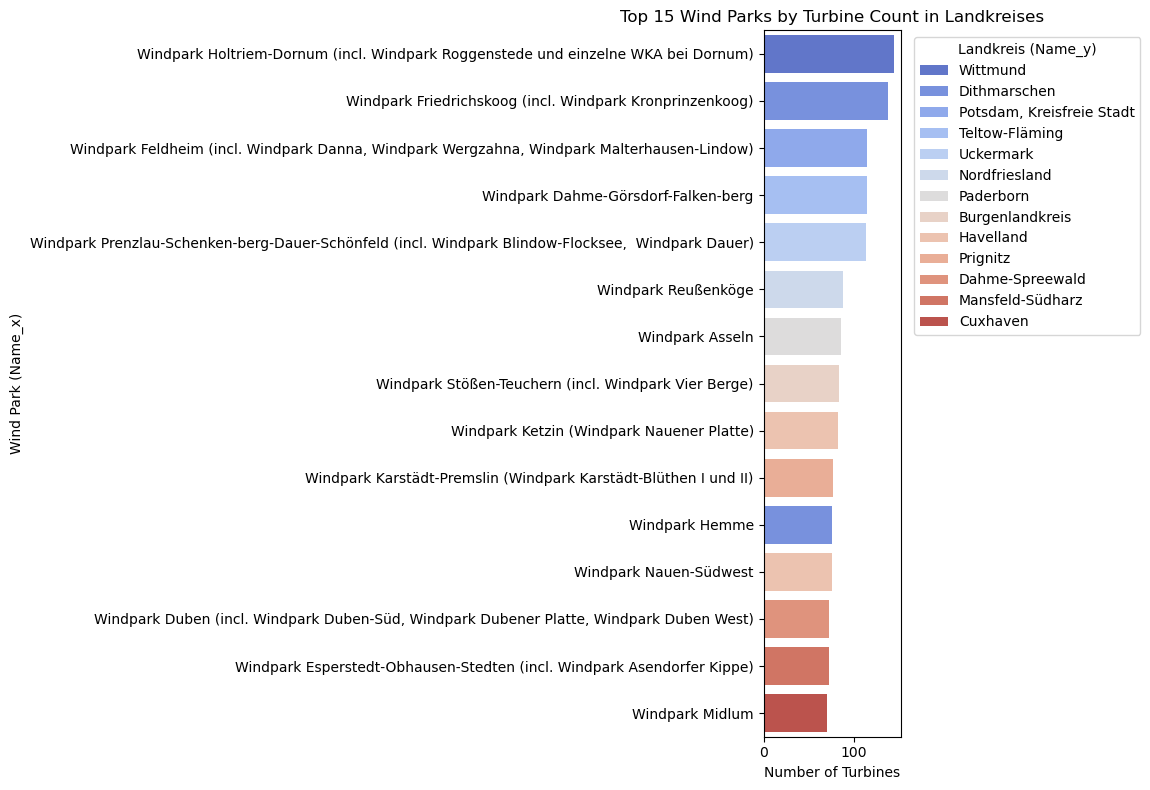

In [65]:
# Top 15 Wind Parks by Turbine Count in Landkreises
top_15_parks = (
    df_exploded.groupby(['Name_x', 'Name_y'])['count']
    .sum()
    .reset_index()
    .sort_values(by='count', ascending=False)
    .head(15)
)

# Bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='count',
    y='Name_x',
    data=top_15_parks,
    hue='Name_y',
    dodge=False,
    palette='coolwarm'
)
plt.title('Top 15 Wind Parks by Turbine Count in Landkreises')
plt.xlabel('Number of Turbines')
plt.ylabel('Wind Park (Name_x)')
plt.legend(title='Landkreis (Name_y)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

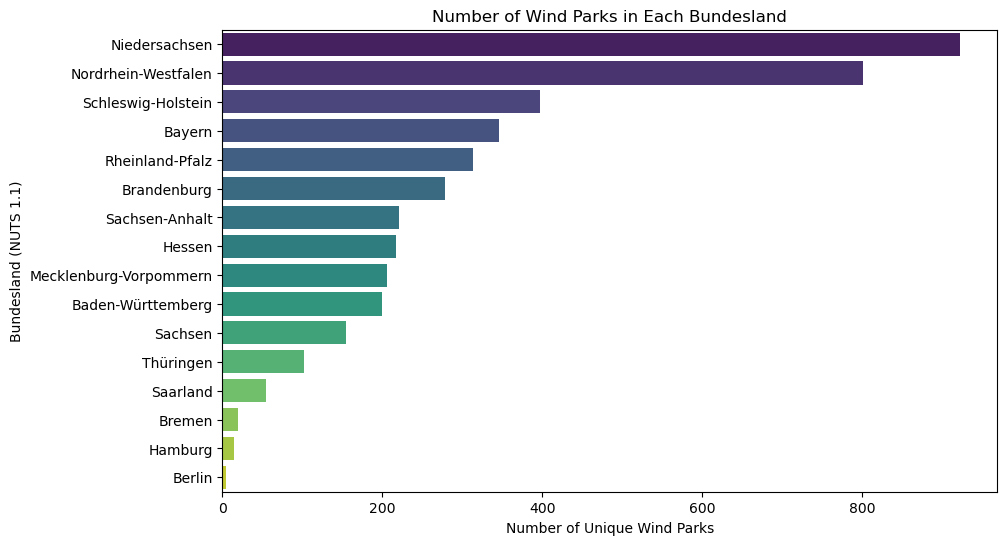

In [66]:
# Number of Wind Parks in Each Bundesland
parks_per_bundesland = df.groupby('NUTS 1.1')['Name_x'].nunique().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=parks_per_bundesland.values, y=parks_per_bundesland.index, palette='viridis')
plt.title('Number of Wind Parks in Each Bundesland')
plt.xlabel('Number of Unique Wind Parks')
plt.ylabel('Bundesland (NUTS 1.1)')
plt.show()

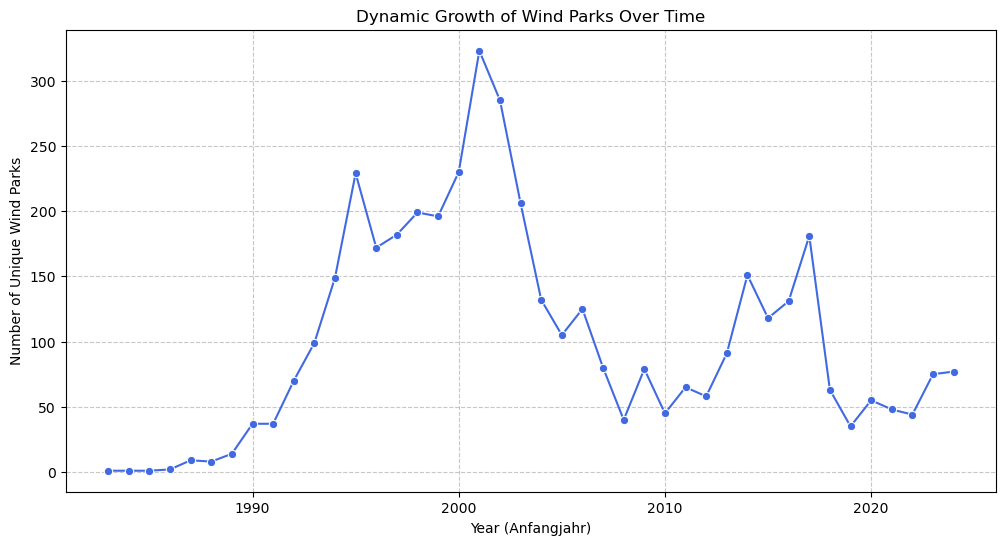

In [67]:
# Dynamic Growth of Wind Parks Over Time
parks_per_year = df.groupby('Anfangjahr')['Name_x'].nunique().reset_index()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='Anfangjahr',
    y='Name_x',
    data=parks_per_year,
    marker='o',
    color='royalblue'
)
plt.title('Dynamic Growth of Wind Parks Over Time')
plt.xlabel('Year (Anfangjahr)')
plt.ylabel('Number of Unique Wind Parks')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

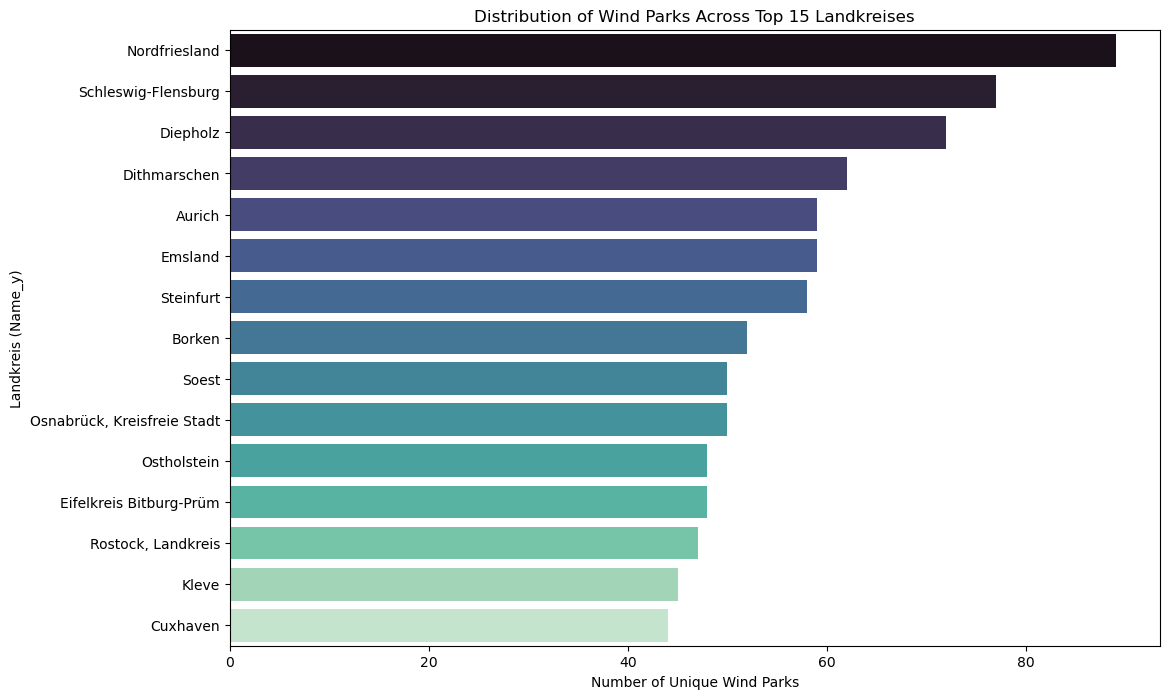

In [68]:
# Distribution of Wind Parks Across Landkreises
parks_per_landkreis = df.groupby('Name_y')['Name_x'].nunique().sort_values(ascending=False).head(15)

# Bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=parks_per_landkreis.values,
    y=parks_per_landkreis.index,
    palette='mako'
)
plt.title('Distribution of Wind Parks Across Top 15 Landkreises')
plt.xlabel('Number of Unique Wind Parks')
plt.ylabel('Landkreis (Name_y)')
plt.show()

In [69]:
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8827 entries, 0 to 4250
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name_x                    8827 non-null   object 
 1   Baujahr                   8827 non-null   object 
 2   Anfangjahr                8825 non-null   float64
 3   Gesamtleistung (MW)       8827 non-null   float64
 4   Anzahl                    8827 non-null   int64  
 5   Ort                       8827 non-null   object 
 6   Landkreis                 8827 non-null   object 
 7   Projektierer / Betreiber  7005 non-null   object 
 8   Bemerkungen               4890 non-null   object 
 9   Latitude                  8827 non-null   object 
 10  Longitude                 8827 non-null   object 
 11  Land                      8827 non-null   object 
 12  Code                      8827 non-null   object 
 13  NUTS 1.1                  8827 non-null   object 
 14  NUTS 2.1     

In [76]:
df_final=df_exploded[['Name_x', 'Anfangjahr', 'Gesamtleistung (MW)', 'Anzahl', 'Landkreis', 'NUTS 1.1','Landkreis', 'type', 'count', 'is_modern', 'modern_count', 'Manufacturer']]

In [72]:
df_final.to_csv('onshores_windparks.csv', index=False)

In [75]:
df_final

Name_x  Anfangjahr  Gesamtleistung (MW)  \
0       Forschungswindkraftanlage RedoxWind      2017.0                2.000   
1          Windkraftanlage Alexanderschanze      2003.0                1.500   
2                Windkraftanlage Alpirsbach      1999.0                2.300   
3                  Windkraftanlage Auenberg      1990.0                0.095   
4     Windkraftanlage auf dem Hohwartsattel      1992.0                0.300   
...                                     ...         ...                  ...   
4248                    Windpark Zehlendorf      2003.0                2.000   
4249                  Windpark Zitz-Warchau      2003.0               30.000   
4250                        Windpark Zossen      2002.0                7.800   
4250                        Windpark Zossen      2002.0                7.800   
4250                        Windpark Zossen      2002.0                7.800   

      Anzahl Landkreis           NUTS 1.1                   type  count  \
0          1        KA  Baden-Württemberg              Qreon Q82    1.0   
1          1        OG  Baden-Württemberg            Südwind S70    1.0   
2          1       FDS  Baden-Württemberg        Enercon E-70 E4    1.0   
3          1        VS  Baden-Württemberg       Reymo DANmark 22    1.0   
4          1        FR  Baden-Württemberg           Enercon E-33    1.0   
...      ...       ...                ...                    ...    ...   
4248       3       OHV        Brandenburg       Vestas V47-660kW    3.0   
4249      20        PM        Brandenburg  NEG Micon NM 64c/1500   20.0   
4250       4        TF        Brandenburg     Enercon E-66/18.70    1.0   
4250       4        TF        Brandenburg     Enercon E-66/20.70    1.0   
4250       4        TF        Brandenburg       Vestas V80-2.0MW    2.0   

      is_modern  modern_count Manufacturer  
0         False          28.0        Qreon  
1         False          32.0      Sudwind  
2         False          57.0      Enercon  
3         False           4.0        Reymo  
4         False           9.0      Enercon  
...         ...           ...          ...  
4248      False          32.0       Vestas  
4249      False          32.0        Micon  
4250      False          51.0      Enercon  
4250      False          51.0      Enercon  
4250      False          51.0       Vestas  

[8827 rows x 11 columns]